In [1]:
# !pip install matplotlib
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

print(len(chain))
print(chain[-1].time)

891137
2025-04-06 02:46:00


# Anonymity Degradation


## setup

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial
import matplotlib.ticker as mticker
import matplotlib.dates as mdates


def plot_anonymity_degradation(
    original_data, 
    after_day_data, 
    after_week_data, 
    after_month_data, 
    after_year, 
    after_all, 
    tag, 
    subtag="", 
    title="", 
    ymin=0,
    legend=False,
    legend_pos="lower left",
    bucket=None,
    until="2025-12-12"
):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
            
    # Determine the denominator key based on the tag
    denominator_key = "not_ignored_outputs" if "ignored" in tag else "all_outputs" if "all outputs" in tag else "not_remixed_outputs"
    def compute(tx):
        cnt = 0
        l, r = bucket
        for o in tx.outputs:
            if l < o.value <= r:
                cnt += 1
        return cnt

    def create_df(data, column_name):
        # Helper function to create DataFrames, reducing repetition
        return pd.DataFrame(
            [
                (
                    transaction.block_time,
                    # Use .get() for safety, default to 1 if key missing or value is 0/None
                    data_dict.get("total_count", 0) / (data_dict.get(denominator_key) or 1) if not bucket else compute(transaction)
                 )
                for transaction, data_dict in data.items()
                # Ensure total_count > 0 and the relevant denominator > 0
                if data_dict.get("total_count", 0) > 0 and (data_dict.get(denominator_key) or 0) > 0 and str(transaction.block_time) <= until
            ],
            columns=["block_time", column_name],
        )

    def create_line(data, column_name):
        return pd.DataFrame(
            [
                (
                    transaction.block_time,
                    # Use .get() for safety, default to 1 if key missing or value is 0/None
                    1 - (data_dict.get("not_remixed_outputs", 0) / (data_dict.get("all_outputs") or 1))
                 )
                for transaction, data_dict in data.items()
                # Ensure total_count > 0 and the relevant denominator > 0
                if data_dict.get("not_remixed_outputs", 0) > 0 and (data_dict.get("all_outputs") or 0) > 0
            ],
            columns=["block_time", column_name],
        )

    df_original = create_df(original_data, "original_anonymity_score")
    df_after_day = create_df(after_day_data, "anonymity_set_after_day")
    df_after_week = create_df(after_week_data, "anonymity_set_after_week")
    df_after_month = create_df(after_month_data, "anonymity_set_after_month")
    df_after_year = create_df(after_year, "anonymity_set_after_year")
    df_after_all = create_df(after_all, "anonymity_set_after_all")
    df_remix_count = create_line(original_data, "remix_count")
    
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_day["block_time"] = pd.to_datetime(df_after_day["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    df_after_year["block_time"] = pd.to_datetime(df_after_year["block_time"])
    df_after_all["block_time"] = pd.to_datetime(df_after_all["block_time"])
    df_remix_count["block_time"] = pd.to_datetime(df_remix_count["block_time"])

    
    df_original["week_start"] = df_original["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_after_day["week_start"] = df_after_day["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_after_year["week_start"] = df_after_year["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_after_all["week_start"] = df_after_all["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    df_remix_count["week_start"] = df_remix_count["block_time"].dt.to_period("D").apply(lambda r: r.start_time)
    
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_day = df_after_day.groupby("week_start")["anonymity_set_after_day"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    weekly_after_year = df_after_year.groupby("week_start")["anonymity_set_after_year"].mean().reset_index()
    weekly_after_all = df_after_all.groupby("week_start")["anonymity_set_after_all"].mean().reset_index()
    remix_count = df_remix_count.groupby("week_start")["remix_count"].mean().reset_index()
    
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_day, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_year, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_all, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, remix_count, on="week_start", how="outer")

    plt.rcParams.update({'font.size': 28})
    plt.figure(figsize=(16, 12))

    colors = plt.cm.viridis([0.95, 0.8, 0.65, 0.5, 0.35, 0.15])
    x = weekly_data["week_start"]

    value_columns = [
        "original_anonymity_score",
        "anonymity_set_after_day",
        "anonymity_set_after_week",
        "anonymity_set_after_month",
        "anonymity_set_after_year",
        "anonymity_set_after_all"
    ]

    # Filter out columns that might not exist in weekly_data
    cols_to_check = [col for col in value_columns if col in weekly_data.columns]
    

    # Fill between lines, starting from the top
    # Ensure columns exist before trying to plot them

    plt.fill_between(
        x,
        weekly_data["original_anonymity_score"], # Use fillna(0) here just for plotting if NaNs cause issues
        weekly_data["anonymity_set_after_day"],
        label="Degradation within 1 day",
        color=colors[0],
    )

    plt.fill_between(
        x,
        weekly_data["anonymity_set_after_day"],
        weekly_data["anonymity_set_after_week"],
        label="Degradation: 1 day - 1 week",
        color=colors[1],
    )

    plt.fill_between(
        x,
        weekly_data["anonymity_set_after_week"],
        weekly_data["anonymity_set_after_month"],
        label="Degradation: 1 week - 1 month",
        color=colors[2],
    )

    plt.fill_between(
        x,
        weekly_data["anonymity_set_after_month"],
        weekly_data["anonymity_set_after_year"],
        label="Degradation: 1 month - 1 year",
        color=colors[3],
    )

    plt.fill_between(
        x,
        weekly_data["anonymity_set_after_year"],
        weekly_data["anonymity_set_after_all"],
        label="Degradation: 1 year - All time",
        color=colors[4],
    )

    # Fill the area for the remaining anonymity (after all time) down to zero

    plt.fill_between(
        x,
        weekly_data["anonymity_set_after_all"], # Fill between the line and 0
        label="Remaining anonymity set (all time)",
        color=colors[5],
    )

    # plt.plot(x, weekly_data["remix_count"].fillna(0), label="Number of remixes", color="red")
    
    # --- Plot Formatting ---
    # plt.xlabel("Year")
    plt.ylabel("Unconsolidated outputs")
    plt.title(title)
    # plt.grid(True, linestyle='--', alpha=0.6)

    # Set Y limits based on the 0-1 data scale (important!)
    plt.ylim(ymin=ymin, ymax=1)


    ax = plt.gca()
    # Create a formatter function that multiplies by 100 and adds '%'
    # Use .0f to display whole numbers (e.g., 80%) instead of 80.0%
    percent_formatter = mticker.FuncFormatter(lambda y, pos: f'{y * 100:.0f}%')

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(percent_formatter)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    ax.margins(x=0)

    if legend:
        plt.legend(loc=legend_pos)
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/results/jura/paper_{tag}{'_' + subtag if subtag else ''}.png")
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log2, factorial

def compute_and_plot_differences(original_data, after_day_data, after_week_data, after_month_data, after_year_data, tag, subtag=""):
    denominator_key = "not_remixed_not_ignored_outputs" if "ignored" in tag else "all_outputs" if "all outputs" in tag else "not_remixed_outputs"
    def create_df(data, column_name):
        # Helper function to create DataFrames, reducing repetition
        df = pd.DataFrame(
            [
                (
                    transaction.block_time,
                    # Use .get() for safety, default to 1 if key missing or value is 0/None
                    data_dict.get("total_count", 0) / (data_dict.get(denominator_key) or 1)
                 )
                for transaction, data_dict in data.items()
                # Ensure total_count > 0 and the relevant denominator > 0
                if data_dict.get("total_count", 0) > 0 and (data_dict.get(denominator_key) or 0) > 0
            ],
            columns=["block_time", column_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
        return df

    df_original = create_df(original_data, "original_value")
    df_after_day = create_df(after_day_data, "after_day_value")
    df_after_week = create_df(after_week_data, "after_week_value")
    df_after_month = create_df(after_month_data, "after_month_value")
    df_after_year = create_df(after_year_data, "after_year_value")

    df_original = df_original.groupby("week_start")["original_value"].mean().reset_index()
    df_after_day = df_after_day.groupby("week_start")["after_day_value"].mean().reset_index()
    df_after_week = df_after_week.groupby("week_start")["after_week_value"].mean().reset_index()
    df_after_month = df_after_month.groupby("week_start")["after_month_value"].mean().reset_index()
    df_after_year = df_after_year.groupby("week_start")["after_year_value"].mean().reset_index()

    merged = df_original.merge(df_after_day, on="week_start", how="outer")
    merged = merged.merge(df_after_week, on="week_start", how="outer")
    merged = merged.merge(df_after_month, on="week_start", how="outer")
    merged = merged.merge(df_after_year, on="week_start", how="outer")

    merged["diff_0_1d"] = abs(merged["after_day_value"] - merged["original_value"])
    merged["diff_1d_7d"] = abs(merged["after_week_value"] - merged["after_day_value"])
    merged["diff_7d_31d"] = abs(merged["after_month_value"] - merged["after_week_value"])
    merged["diff_31d_365d"] = abs(merged["after_year_value"] - merged["after_month_value"])

    plt.rcParams.update({'font.size': 24})
    colors = plt.cm.viridis([0.95, 0.8, 0.65, 0.5, 0.35, 0.15])
    
    plt.figure(figsize=(16,6))
    plt.plot(merged["week_start"], merged["diff_0_1d"], label="Difference (0–1d)", color=colors[0])
    plt.plot(merged["week_start"], merged["diff_1d_7d"], label="Difference (1d–7d)", color=colors[1])
    plt.plot(merged["week_start"], merged["diff_7d_31d"], label="Difference (7d–31d)", color=colors[2])
    plt.plot(merged["week_start"], merged["diff_31d_365d"], label="Difference (31d–365d)", color=colors[3])

    plt.xlabel("Month")
    plt.ylabel("Difference in anonymity values")
    plt.title(f"Differences (0–1d, 1d–7d, 7d–31d, 31d-365d) for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.ylim(ymin=0, ymax=1)

    ax = plt.gca()
    # Create a formatter function that multiplies by 100 and adds '%'
    # Use .0f to display whole numbers (e.g., 80%) instead of 80.0%
    percent_formatter = mticker.FuncFormatter(lambda y, pos: f'{y * 100:.0f}%')

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(percent_formatter)
    #plt.savefig(f"/mnt/blocksci/anonymity_degradation_differences_{tag}{'_' + subtag if subtag else ''}_all.png")
    plt.show()
    

def compute_and_plot_quartiles(after_day_data, after_year_data, tag, subtag="", title=""):
    denominator_key = "not_remixed_not_ignored_outputs" if "ignored" in tag else "all_outputs" if "all outputs" in tag else "not_remixed_outputs"
    def create_df(data, column_name):
        # Helper function to create DataFrames, reducing repetition
        df = pd.DataFrame(
            [
                (
                    transaction.block_time,
                    # Use .get() for safety, default to 1 if key missing or value is 0/None
                    data_dict.get("total_count", 0) / (data_dict.get(denominator_key) or 1)
                 )
                for transaction, data_dict in data.items()
                # Ensure total_count > 0 and the relevant denominator > 0
                if data_dict.get("total_count", 0) > 0 and (data_dict.get(denominator_key) or 0) > 0
            ],
            columns=["block_time", column_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
        return df
        

    df_after_day = create_df(after_day_data, "after_day_value")
    df_after_year = create_df(after_year_data, "after_year_value")

    merged = pd.merge(df_after_day, df_after_year, on=["block_time","week_start"], how="outer")

    weekly = merged.groupby("week_start").agg({
        "after_day_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        "after_year_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
    }).reset_index()

    weekly.columns = [
        "week_start",
        "after_day_mean", "after_day_q1", "after_day_median", "after_day_q3",
        "after_year_mean", "after_year_q1", "after_year_median", "after_year_q3"
    ]

    colors = plt.cm.viridis([0.95, 0.8, 0.65, 0.5, 0.35, 0.15])
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(16, 8))
    plt.plot(weekly["week_start"], weekly["after_day_mean"], label="After 1 day (mean)", color=colors[0])
    plt.fill_between(weekly["week_start"], weekly["after_day_q1"], weekly["after_day_q3"], color=colors[0], alpha=0.3, label="1 day (Q1–Q3)")

    plt.plot(weekly["week_start"], weekly["after_year_mean"], label="After 1 year (mean)", color=colors[3])
    plt.fill_between(weekly["week_start"], weekly["after_year_q1"], weekly["after_year_q3"], color=colors[3], alpha=0.3, label="1 year (Q1–Q3)")
    
    # plt.xlabel("Year")
    plt.ylabel("Percentage of unconsolidated outputs")
    plt.title(title)
    plt.grid(True)
    plt.ylim(ymin=0.4, ymax=1)

    ax = plt.gca()
    # Create a formatter function that multiplies by 100 and adds '%'
    # Use .0f to display whole numbers (e.g., 80%) instead of 80.0%
    percent_formatter = mticker.FuncFormatter(lambda y, pos: f'{y * 100:.0f}%')

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(percent_formatter)
    formatter = mdates.DateFormatter("%Y") ### formatter of the date
    locator = mdates.YearLocator() ### where to put the labels
    ax.xaxis.set_major_formatter(formatter) ## calling the formatter for the x-axis
    ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis
    ax.margins(x=0)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/results/jura/paper_quartiles{tag}{'_' + subtag if subtag else ''}_new.png")
    plt.show()

## computation

### base

In [23]:
import json
with open('/mnt/anal/false_cjtxs.json', 'r') as f:
    data = set(json.loads(f.read()))

ww2_ccjs_try = chain.filter_coinjoin_txes(0, len(chain), "wasabi2")
cnt = 0
print(len(ww2_ccjs_try))
for tx in ww2_ccjs_try:
    if str(tx.hash) in data:
        print(tx.hash)
        cnt += 1

print(cnt)
s = next(iter(data))

for d in data:
    try:
        tx = chain.tx_with_hash(d)
    except:
        continue
    t = blocksci.CoinJoinType(tx.coinjoin_tag)
    if t != blocksci.CoinJoinType.NoCJ:
        print(t)

57457
0
CoinJoinType.WW2PostzkSNACKs


In [ ]:
%time ww1_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1")
%time ww1_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1")
%time ww1_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1")
%time ww1_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1")
%time ww1_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1")
%time ww1_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1")

print('ww1 done')

In [ ]:
%time ww2_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2")
%time ww2_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2")
%time ww2_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2")
%time ww2_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2")
%time ww2_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2")
%time ww2_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2")

print('ww2 done')

In [19]:
%time sw_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool")
%time sw_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool")
%time sw_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool")
%time sw_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool")
%time sw_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool")
%time sw_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool")

%time sw_original_data_50m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "50m")
%time sw_after_day_data_50m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "50m")
%time sw_after_week_data_50m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "50m")
%time sw_after_month_data_50m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "50m")
%time sw_after_year_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "50m")
%time sw_after_full_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "50m")

%time sw_original_data_5m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "5m")
%time sw_after_day_data_5m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "5m")
%time sw_after_week_data_5m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "5m")
%time sw_after_month_data_5m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "5m")
%time sw_after_year_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "5m")
%time sw_after_full_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "5m")

%time sw_original_data_1m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "1m")
%time sw_after_day_data_1m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "1m")
%time sw_after_week_data_1m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "1m")
%time sw_after_month_data_1m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "1m")
%time sw_after_year_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "1m")
%time sw_after_full_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "1m")

%time sw_original_data_100k = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "100k")
%time sw_after_day_data_100k = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "100k")
%time sw_after_week_data_100k = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "100k")
%time sw_after_month_data_100k = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "100k")
%time sw_after_year_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "100k")
%time sw_after_full_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "100k")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f22ba334d90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


CPU times: user 10min 44s, sys: 2.45 s, total: 10min 47s
Wall time: 14.1 s
CPU times: user 1h 12min 48s, sys: 9.38 s, total: 1h 12min 57s
Wall time: 39.1 s
CPU times: user 1h 17min 37s, sys: 9.62 s, total: 1h 17min 47s
Wall time: 41.4 s
CPU times: user 1h 15min 4s, sys: 12.6 s, total: 1h 15min 17s
Wall time: 43.2 s
CPU times: user 1h 16min 39s, sys: 8.29 s, total: 1h 16min 48s
Wall time: 45.9 s
CPU times: user 1h 18min 48s, sys: 10.6 s, total: 1h 18min 58s
Wall time: 44 s
CPU times: user 9min 51s, sys: 1.08 s, total: 9min 52s
Wall time: 7.43 s
CPU times: user 51min 39s, sys: 4.71 s, total: 51min 44s
Wall time: 26 s
CPU times: user 51min 50s, sys: 2.74 s, total: 51min 53s
Wall time: 26.3 s
CPU times: user 51min 51s, sys: 2.33 s, total: 51min 53s
Wall time: 23.8 s
CPU times: user 51min 50s, sys: 2.4 s, total: 51min 53s
Wall time: 25.7 s
CPU times: user 55min 21s, sys: 4.36 s, total: 55min 25s
Wall time: 27.6 s
CPU times: user 10min 9s, sys: 916 ms, total: 10min 9s
Wall time: 8.06 s
CPU t

In [ ]:
%time ww1_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ignoreNonStandardDenominations=True)

%time ww2_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ignoreNonStandardDenominations=True)

### noremix

In [21]:
%time ww1_noremix_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ignoreRemixes=False)
%time ww1_noremix_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ignoreRemixes=False)
%time ww1_noremix_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ignoreRemixes=False)
%time ww1_noremix_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ignoreRemixes=False)
%time ww1_noremix_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ignoreRemixes=False)
%time ww1_noremix_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ignoreRemixes=False)

%time ww2_noremix_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ignoreRemixes=False)
%time ww2_noremix_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ignoreRemixes=False)
%time ww2_noremix_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ignoreRemixes=False)
%time ww2_noremix_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ignoreRemixes=False)
%time ww2_noremix_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ignoreRemixes=False)
%time ww2_noremix_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ignoreRemixes=False)

%time sw_noremix_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", ignoreRemixes=False)
%time sw_noremix_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", ignoreRemixes=False)
%time sw_noremix_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", ignoreRemixes=False)
%time sw_noremix_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", ignoreRemixes=False)
%time sw_noremix_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", ignoreRemixes=False)
%time sw_noremix_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", ignoreRemixes=False)

CPU times: user 7min, sys: 1.18 s, total: 7min 1s
Wall time: 18.1 s
CPU times: user 49min 53s, sys: 4.39 s, total: 49min 57s
Wall time: 54.1 s
CPU times: user 50min 7s, sys: 4.62 s, total: 50min 11s
Wall time: 57.2 s
CPU times: user 50min 43s, sys: 4.52 s, total: 50min 47s
Wall time: 55.9 s
CPU times: user 50min 43s, sys: 3.71 s, total: 50min 47s
Wall time: 57.1 s
CPU times: user 49min 50s, sys: 4.49 s, total: 49min 55s
Wall time: 55.7 s
CPU times: user 7min, sys: 1.09 s, total: 7min 2s
Wall time: 19.4 s
CPU times: user 50min 10s, sys: 3.56 s, total: 50min 13s
Wall time: 1min 3s
CPU times: user 51min 29s, sys: 4.69 s, total: 51min 33s
Wall time: 1min 3s
CPU times: user 52min 31s, sys: 3.84 s, total: 52min 34s
Wall time: 1min 4s
CPU times: user 52min 30s, sys: 4.25 s, total: 52min 35s
Wall time: 1min 2s
CPU times: user 52min 13s, sys: 4.84 s, total: 52min 17s
Wall time: 1min 2s
CPU times: user 9min 10s, sys: 2.06 s, total: 9min 12s
Wall time: 24.7 s
CPU times: user 1h 45s, sys: 7.23 s, 

In [3]:
%time ww2_noremix_original_data_50m = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
%time ww2_noremix_after_day_data_50m = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
%time ww2_noremix_after_week_data_50m = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
%time ww2_noremix_after_month_data_50m = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
%time ww2_noremix_after_year_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
%time ww2_noremix_after_full_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ww2DenomsBucket=(5000000, 50000000), ignoreRemixes=False)
print('50m')

%time ww2_noremix_original_data_5m = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
%time ww2_noremix_after_day_data_5m = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
%time ww2_noremix_after_week_data_5m = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
%time ww2_noremix_after_month_data_5m = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
%time ww2_noremix_after_year_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
%time ww2_noremix_after_full_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ww2DenomsBucket=(1000000, 5000000), ignoreRemixes=False)
print('5m')

%time ww2_noremix_original_data_1m = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
%time ww2_noremix_after_day_data_1m = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
%time ww2_noremix_after_week_data_1m = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
%time ww2_noremix_after_month_data_1m = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
%time ww2_noremix_after_year_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
%time ww2_noremix_after_full_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ww2DenomsBucket=(100000, 1000000), ignoreRemixes=False)
print('1m')

%time ww2_noremix_original_data_100k = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
%time ww2_noremix_after_day_data_100k = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
%time ww2_noremix_after_week_data_100k = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
%time ww2_noremix_after_month_data_100k = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
%time ww2_noremix_after_year_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
%time ww2_noremix_after_full_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ww2DenomsBucket=(0, 100000), ignoreRemixes=False)
print('100k')

CPU times: user 8min 18s, sys: 51.6 s, total: 9min 10s
Wall time: 9.9 s
CPU times: user 54min 45s, sys: 8.83 s, total: 54min 54s
Wall time: 25.9 s
CPU times: user 53min 27s, sys: 6.5 s, total: 53min 34s
Wall time: 25.7 s
CPU times: user 54min 8s, sys: 5.68 s, total: 54min 14s
Wall time: 26.4 s
CPU times: user 55min 6s, sys: 5 s, total: 55min 11s
Wall time: 27 s
CPU times: user 54min 36s, sys: 5.42 s, total: 54min 41s
Wall time: 26.6 s
50m
CPU times: user 8min 51s, sys: 1.19 s, total: 8min 52s
Wall time: 9.46 s
CPU times: user 53min 23s, sys: 5.49 s, total: 53min 28s
Wall time: 25.7 s
CPU times: user 53min 55s, sys: 5.47 s, total: 54min 1s
Wall time: 26.7 s
CPU times: user 54min 23s, sys: 7.7 s, total: 54min 30s
Wall time: 26.4 s
CPU times: user 55min 8s, sys: 4.32 s, total: 55min 12s
Wall time: 26.6 s
CPU times: user 55min 24s, sys: 6.62 s, total: 55min 30s
Wall time: 28.1 s
5m
CPU times: user 8min 48s, sys: 1.08 s, total: 8min 49s
Wall time: 9.33 s
CPU times: user 53min 48s, sys: 4.65

In [4]:
# Udlej prosim 0.09 - 0.11, 0.19 - 0.21, 0.39 - 0.41, 0.79-0.81
%time ww1_noremix_original_data_04 = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
%time ww1_noremix_after_day_data_04 = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
%time ww1_noremix_after_week_data_04 = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
%time ww1_noremix_after_month_data_04 = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
%time ww1_noremix_after_year_data_04 = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
%time ww1_noremix_after_full_data_04 = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ww2DenomsBucket=(39000000, 42900000), ignoreRemixes=False)
print('04')

%time ww1_noremix_original_data_022 = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
%time ww1_noremix_after_day_data_022 = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
%time ww1_noremix_after_week_data_022 = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
%time ww1_noremix_after_month_data_022 = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
%time ww1_noremix_after_year_data_022 = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
%time ww1_noremix_after_full_data_022 = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ww2DenomsBucket=(19000000, 22900000), ignoreRemixes=False)
print('022')

%time ww1_noremix_original_data_012 = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
%time ww1_noremix_after_day_data_012 = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
%time ww1_noremix_after_week_data_012 = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
%time ww1_noremix_after_month_data_012 = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
%time ww1_noremix_after_year_data_012 = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
%time ww1_noremix_after_full_data_012 = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ww2DenomsBucket=(900000, 12000000), ignoreRemixes=False)
print('012')

CPU times: user 8min 57s, sys: 1.32 s, total: 8min 58s
Wall time: 8.09 s
CPU times: user 50min 26s, sys: 2.4 s, total: 50min 29s
Wall time: 23.7 s
CPU times: user 51min 5s, sys: 1.71 s, total: 51min 7s
Wall time: 24 s
CPU times: user 50min 18s, sys: 2.61 s, total: 50min 21s
Wall time: 25.2 s
CPU times: user 53min 53s, sys: 3.36 s, total: 53min 57s
Wall time: 27.1 s
CPU times: user 55min 10s, sys: 3.19 s, total: 55min 13s
Wall time: 25.8 s
04
CPU times: user 8min 47s, sys: 858 ms, total: 8min 48s
Wall time: 7.78 s
CPU times: user 55min 58s, sys: 3.61 s, total: 56min 1s
Wall time: 25.7 s
CPU times: user 57min 31s, sys: 3.86 s, total: 57min 35s
Wall time: 25.4 s
CPU times: user 57min 5s, sys: 3.07 s, total: 57min 8s
Wall time: 25.7 s
CPU times: user 57min 46s, sys: 3.25 s, total: 57min 49s
Wall time: 26.2 s
CPU times: user 57min 27s, sys: 3.13 s, total: 57min 30s
Wall time: 26.5 s
022
CPU times: user 8min 50s, sys: 1.12 s, total: 8min 51s
Wall time: 7.91 s
CPU times: user 58min 13s, sys: 

In [5]:
%time sw_noremix_original_data_50m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "50m", ignoreRemixes=False)
%time sw_noremix_after_day_data_50m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "50m", ignoreRemixes=False)
%time sw_noremix_after_week_data_50m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "50m", ignoreRemixes=False)
%time sw_noremix_after_month_data_50m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "50m", ignoreRemixes=False)
%time sw_noremix_after_year_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "50m", ignoreRemixes=False)
%time sw_noremix_after_full_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "50m", ignoreRemixes=False)
print('50m')

%time sw_noremix_original_data_5m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "5m", ignoreRemixes=False)
%time sw_noremix_after_day_data_5m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "5m", ignoreRemixes=False)
%time sw_noremix_after_week_data_5m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "5m", ignoreRemixes=False)
%time sw_noremix_after_month_data_5m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "5m", ignoreRemixes=False)
%time sw_noremix_after_year_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "5m", ignoreRemixes=False)
%time sw_noremix_after_full_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "5m", ignoreRemixes=False)
print('5m')

%time sw_noremix_original_data_1m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "1m", ignoreRemixes=False)
%time sw_noremix_after_day_data_1m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "1m", ignoreRemixes=False)
%time sw_noremix_after_week_data_1m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "1m", ignoreRemixes=False)
%time sw_noremix_after_month_data_1m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "1m", ignoreRemixes=False)
%time sw_noremix_after_year_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "1m", ignoreRemixes=False)
%time sw_noremix_after_full_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "1m", ignoreRemixes=False)
print('1m')

%time sw_noremix_original_data_100k = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "100k", ignoreRemixes=False)
%time sw_noremix_after_day_data_100k = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "100k", ignoreRemixes=False)
%time sw_noremix_after_week_data_100k = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "100k", ignoreRemixes=False)
%time sw_noremix_after_month_data_100k = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "100k", ignoreRemixes=False)
%time sw_noremix_after_year_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "100k", ignoreRemixes=False)
%time sw_noremix_after_full_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "100k", ignoreRemixes=False)
print('100k')

CPU times: user 10min 15s, sys: 1.57 s, total: 10min 16s
Wall time: 6.62 s
CPU times: user 53min 26s, sys: 4.97 s, total: 53min 31s
Wall time: 23.2 s
CPU times: user 52min 56s, sys: 4.46 s, total: 53min 1s
Wall time: 23.7 s
CPU times: user 54min 38s, sys: 7.73 s, total: 54min 46s
Wall time: 22.3 s
CPU times: user 52min 4s, sys: 4.36 s, total: 52min 8s
Wall time: 23.9 s
CPU times: user 51min 54s, sys: 4.94 s, total: 51min 59s
Wall time: 22.5 s
50m
CPU times: user 10min 32s, sys: 1.29 s, total: 10min 33s
Wall time: 7.49 s
CPU times: user 55min 41s, sys: 4.45 s, total: 55min 45s
Wall time: 24.4 s
CPU times: user 56min 21s, sys: 5.56 s, total: 56min 27s
Wall time: 25.2 s
CPU times: user 56min 34s, sys: 4.39 s, total: 56min 39s
Wall time: 25.4 s
CPU times: user 58min 5s, sys: 3.99 s, total: 58min 9s
Wall time: 25.2 s
CPU times: user 58min 55s, sys: 3.96 s, total: 58min 59s
Wall time: 25.6 s
5m
CPU times: user 10min 37s, sys: 995 ms, total: 10min 38s
Wall time: 7.97 s
CPU times: user 59min 2

## Plotting

### all

In [36]:
# plot_anonymity_degradation(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, ww1_after_full_data, "ww1_multiple_txes")
# compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
# compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")

# plot_anonymity_degradation(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, ww2_after_full_data, "ww2_multiple_txes")
# compute_and_plot_differences(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, "ww2_multiple_txes")
# compute_and_plot_quartiles(ww2_after_day_data, ww2_after_year_data, "ww2_cjs")

# plot_anonymity_degradation(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, sw_after_full_data, "sw_multiple_txes")
# compute_and_plot_differences(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, "sw_multiple_txes")
# compute_and_plot_quartiles(sw_after_day_data, sw_after_year_data, "sw_cjs")

# plot_anonymity_degradation(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, sw_after_full_data_50m, "sw_multiple_txes", "50m")
# compute_and_plot_differences(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, "sw_multiple_txes", "50m")
# compute_and_plot_quartiles(sw_after_day_data_50m, sw_after_year_data_50m, "sw_cjs", "50m")

# plot_anonymity_degradation(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, sw_after_full_data_5m, "sw_multiple_txes", "5m")
# compute_and_plot_differences(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, "sw_multiple_txes", "5m")
# compute_and_plot_quartiles(sw_after_day_data_5m, sw_after_year_data_5m, "sw_cjs", "5m")


# plot_anonymity_degradation(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, sw_after_full_data_1m, "sw_multiple_txes", "1m")
# compute_and_plot_differences(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, "sw_multiple_txes", "1m")
# compute_and_plot_quartiles(sw_after_day_data_1m, sw_after_year_data_1m, "sw_cjs", "1m")


# plot_anonymity_degradation(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, sw_after_full_data_100k, "sw_multiple_txes", "100k")
# compute_and_plot_differences(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, "sw_multiple_txes", "100k")
# compute_and_plot_quartiles(sw_after_day_data_100k, sw_after_year_data_100k, "sw_cjs", "100k")

# plot_anonymity_degradation(ww1_ign_original_data, ww1_ign_after_day_data, ww1_ign_after_week_data, ww1_ign_after_month_data, ww1_ign_after_year_data, ww1_ign_after_full_data, "ww1_multiple_txes_ignored", "ignored_without_remixes")
# compute_and_plot_quartiles(ww1_ign_after_day_data, ww1_ign_after_year_data, "ww1_multiple_ignored")
# compute_and_plot_differences(ww1_ign_original_data, ww1_ign_after_day_data, ww1_ign_after_week_data, ww1_ign_after_month_data, ww1_ign_after_year_data, "ww1_multiple_txes_ignored", "ignored_without_remixes")

# plot_anonymity_degradation(ww2_ign_original_data, ww2_ign_after_day_data, ww2_ign_after_week_data, ww2_ign_after_month_data, ww2_ign_after_year_data, ww2_ign_after_full_data, "ww2_multiple_txes_ignored", "ignored_without_remixes")
# compute_and_plot_quartiles(ww2_ign_after_day_data, ww2_ign_after_year_data, "ww2_multiple_ignored")
# compute_and_plot_differences(ww2_ign_original_data, ww2_ign_after_day_data, ww2_ign_after_week_data, ww2_ign_after_month_data, ww2_ign_after_year_data, "ww2_multiple_txes_ignored", "ignored_without_remixes")


# plot_anonymity_degradation(
#     ww1_noremix_original_data, 
#     ww1_noremix_after_day_data, 
#     ww1_noremix_after_week_data, 
#     ww1_noremix_after_month_data, 
#     ww1_noremix_after_year_data, 
#     ww1_noremix_after_full_data, 
#     "ww1_multiple_txes_all outputs", 
#     "with remixes",
#     title="Anonymity set degradation for Wasabi Wallet 1.x",
#     ymin=0.4
# )
# compute_and_plot_quartiles(
#     ww1_noremix_after_day_data, 
#     ww1_noremix_after_year_data, 
#     "ww1_multiple_all outputs"
# )
# compute_and_plot_differences(
#     ww1_noremix_original_data, 
#     ww1_noremix_after_day_data, 
#     ww1_noremix_after_week_data, 
#     ww1_noremix_after_month_data, 
#     ww1_noremix_after_year_data, 
#     "ww1_multiple_txes_all outputs", 
#     "with remixes"
# )

# plot_anonymity_degradation(
#     ww2_noremix_original_data, 
#     ww2_noremix_after_day_data, 
#     ww2_noremix_after_week_data, 
#     ww2_noremix_after_month_data, 
#     ww2_noremix_after_year_data, 
#     ww2_noremix_after_full_data, 
#     "ww2_multiple_txes_all outputs", 
#     "with remixes",
#     title="Anonymity set degradation for Wasabi Wallet 2.x",
#     ymin=0.4,
#     legend=True
# )

# compute_and_plot_quartiles(
#     ww2_noremix_after_day_data, 
#     ww2_noremix_after_year_data, 
#     "ww2_multiple_all outputs",
#     title="Unconsolidated outputs with quartiles for Wasabi Wallet 2.x"
# )
# compute_and_plot_differences(
#     ww2_noremix_original_data, 
#     ww2_noremix_after_day_data, 
#     ww2_noremix_after_week_data, 
#     ww2_noremix_after_month_data, 
#     ww2_noremix_after_year_data, 
#     "ww2_multiple_txes_all outputs", 
#     "with remixes",
# )

# plot_anonymity_degradation(
#     sw_noremix_original_data, 
#     sw_noremix_after_day_data, 
#     sw_noremix_after_week_data, 
#     sw_noremix_after_month_data, 
#     sw_noremix_after_year_data, 
#     sw_noremix_after_full_data, 
#     "sw_multiple_txes_all outputs", 
#     "with remixes",
#     title="Anonymity set degradation for Whirlpool coinjoins",
#     ymin=0.4
# )
# compute_and_plot_quartiles(
#     sw_noremix_after_day_data, 
#     sw_noremix_after_year_data, 
#     "sw_multiple_all outputs"
# )
# compute_and_plot_differences(
#     sw_noremix_original_data, 
#     sw_noremix_after_day_data, 
#     sw_noremix_after_week_data, 
#     sw_noremix_after_month_data, 
#     sw_noremix_after_year_data, 
#     "sw_multiple_txes_all outputs", 
#     "with remixes",
# )



NameError: name 'sw_noremix_original_data_50m' is not defined

### denoms

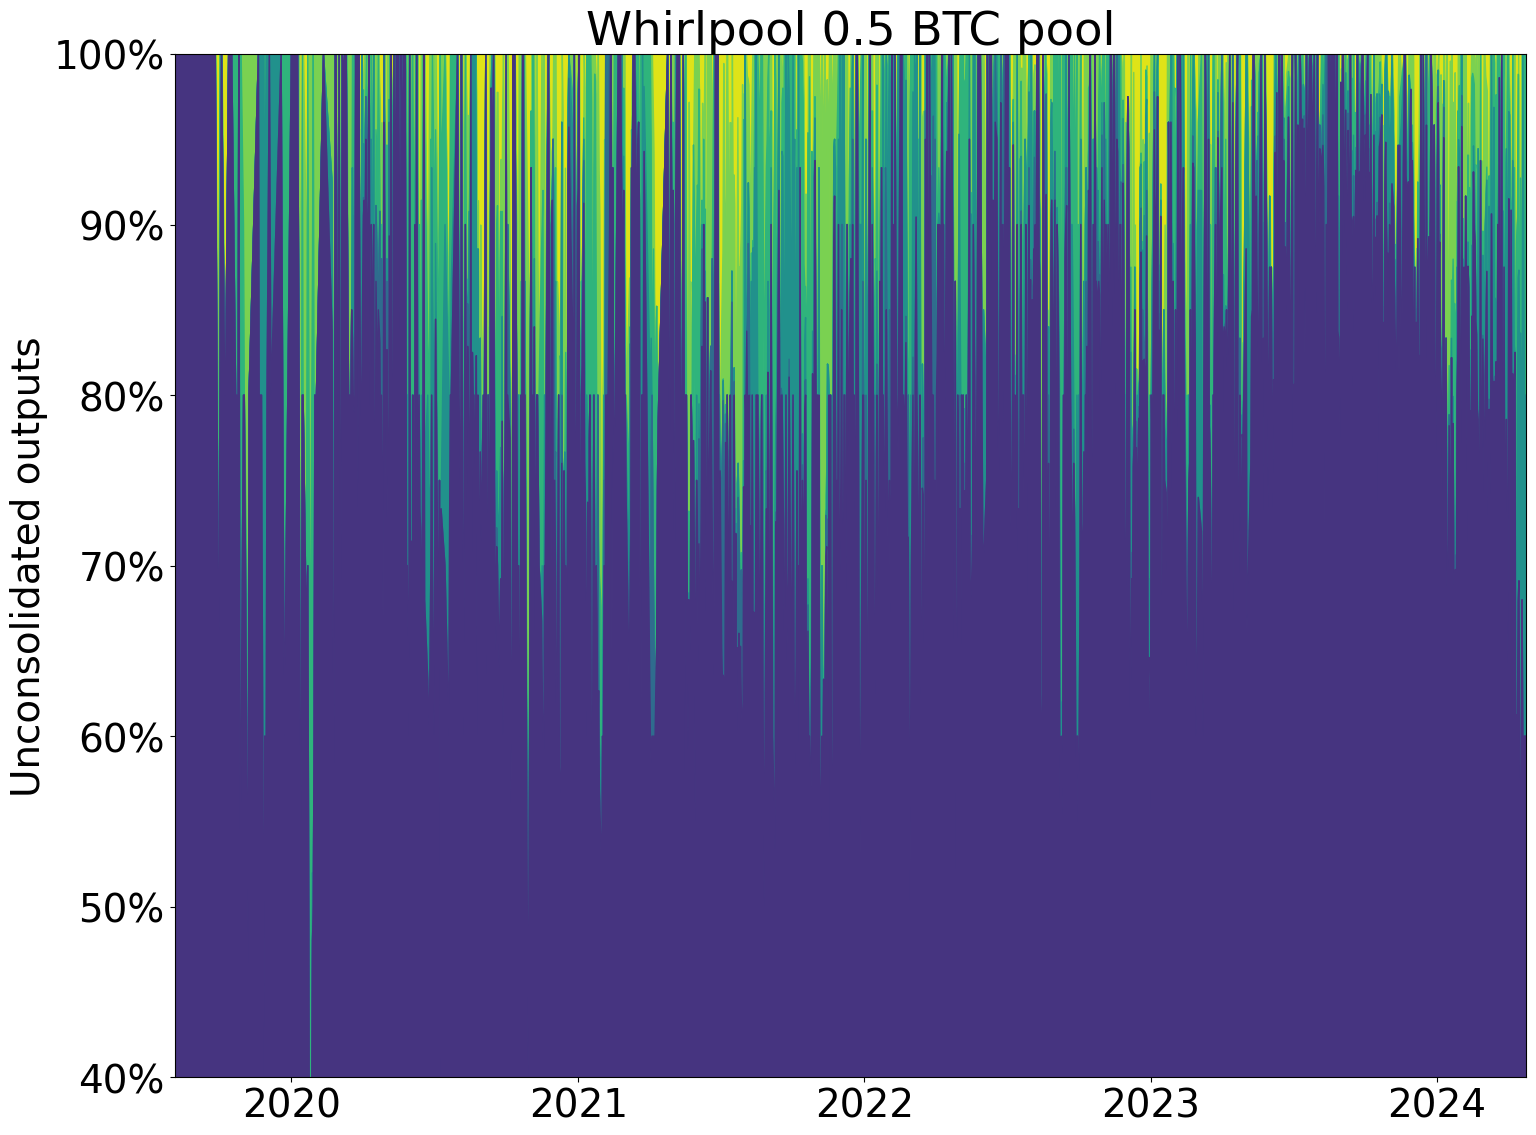

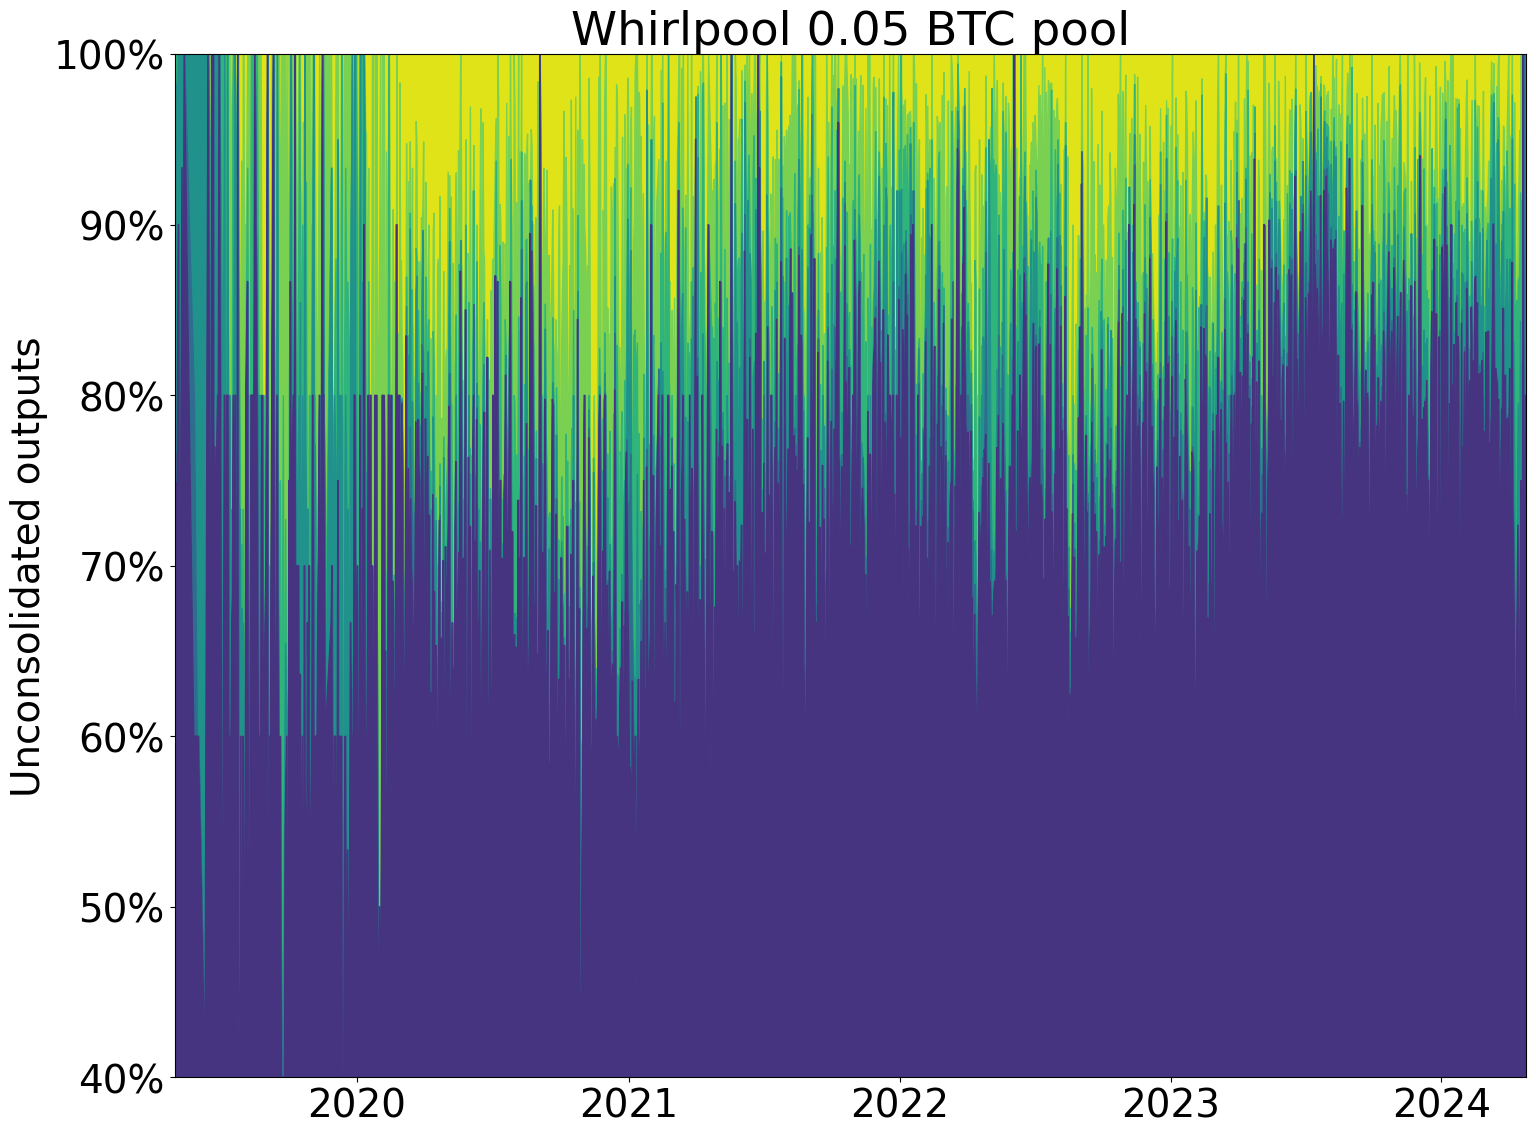

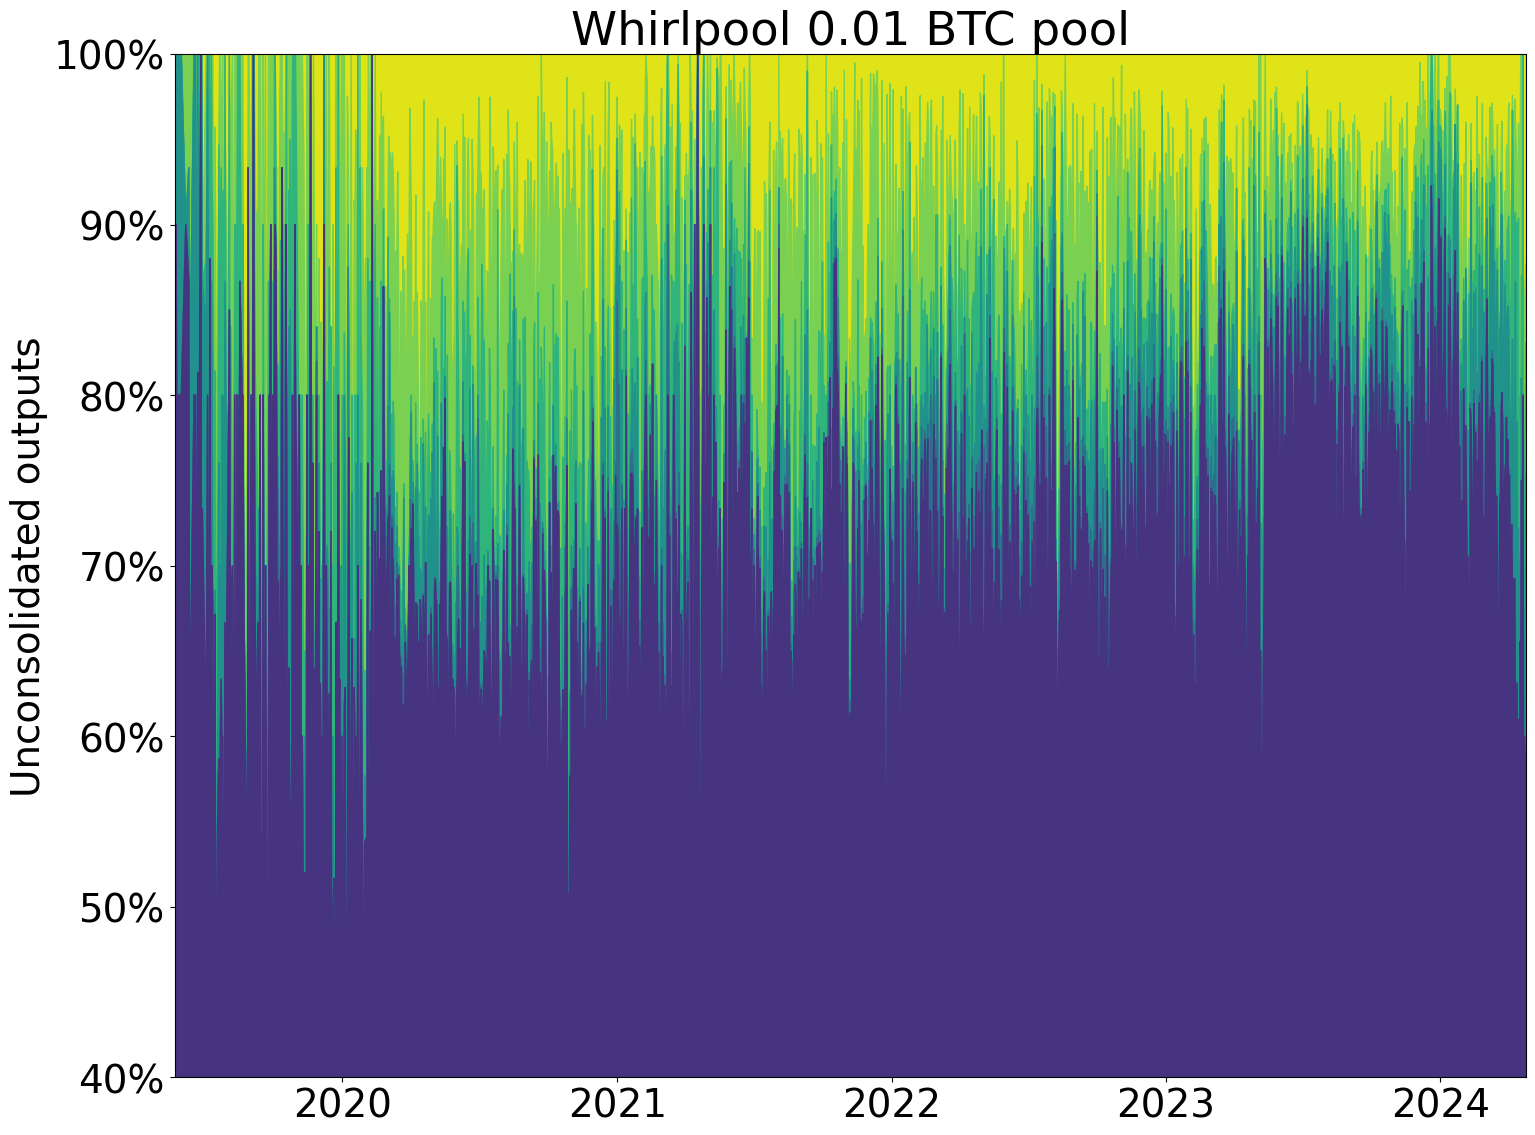

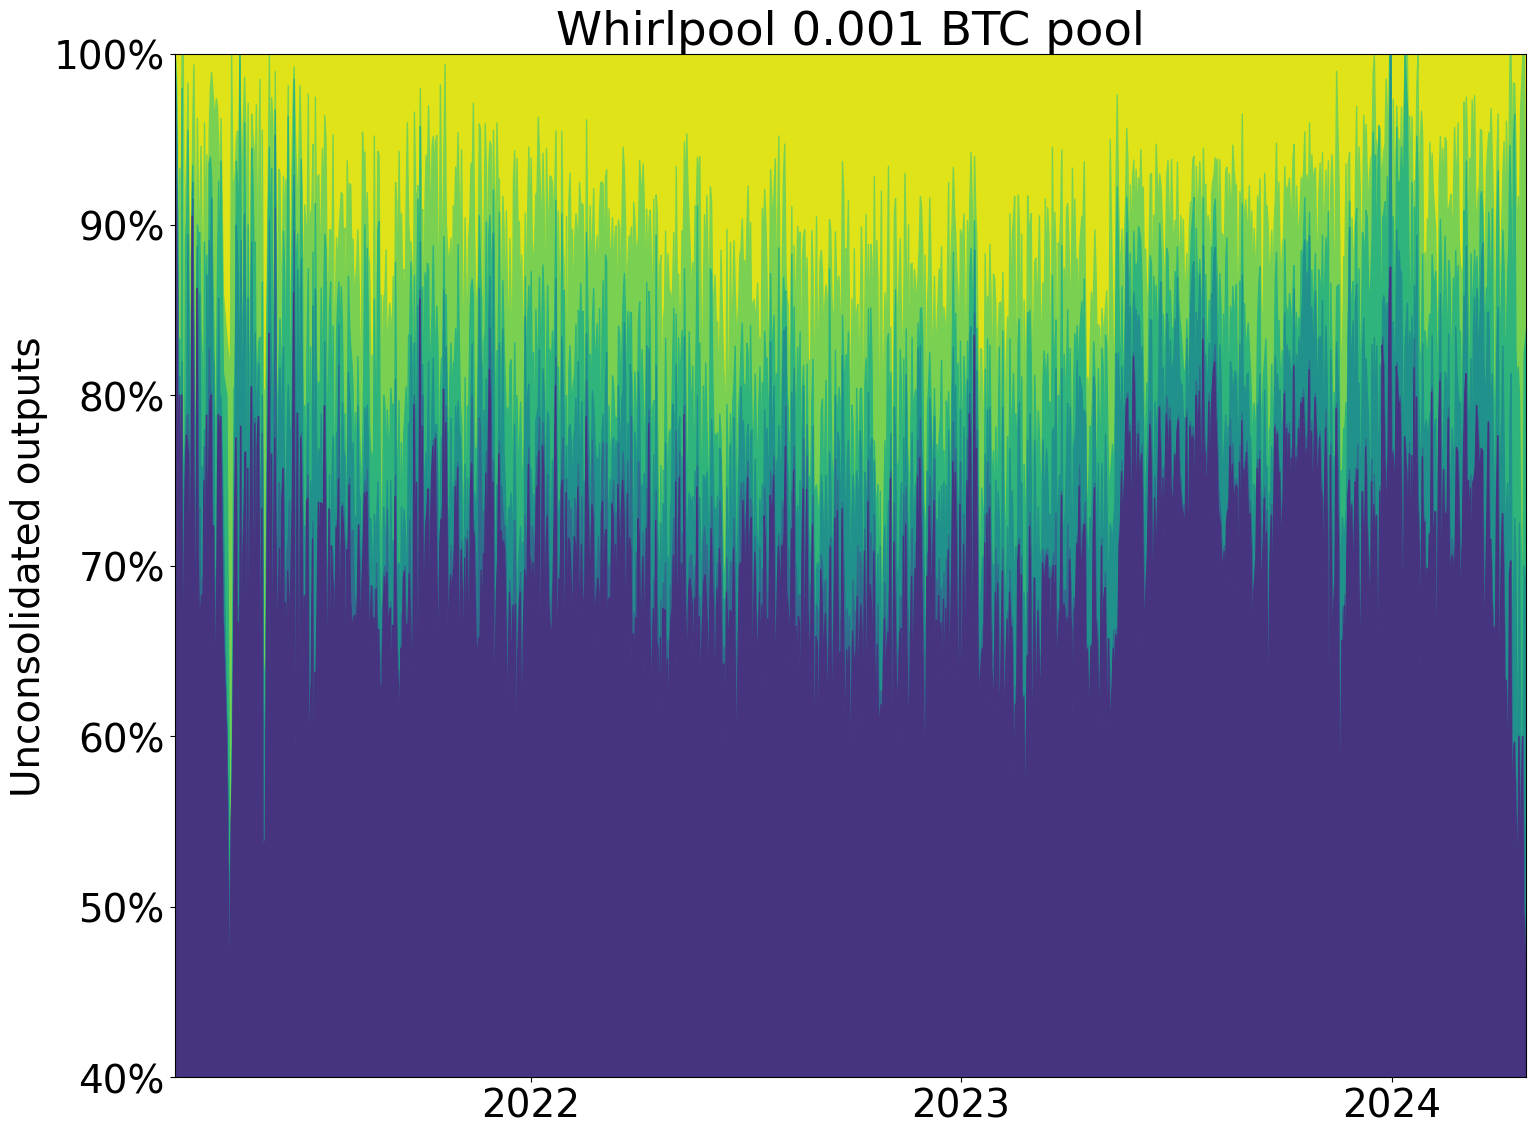

In [10]:
plot_anonymity_degradation(
    sw_noremix_original_data_50m, 
    sw_noremix_after_day_data_50m, 
    sw_noremix_after_week_data_50m, 
    sw_noremix_after_month_data_50m, 
    sw_noremix_after_year_data_50m, 
    sw_noremix_after_full_data_50m, 
    "sw_multiple_txes_all outputs_50m", 
    "with remixes",
    title="Whirlpool 0.5 BTC pool",
    ymin=0.4,
    # legend=True
)

plot_anonymity_degradation(
    sw_noremix_original_data_5m, 
    sw_noremix_after_day_data_5m, 
    sw_noremix_after_week_data_5m, 
    sw_noremix_after_month_data_5m, 
    sw_noremix_after_year_data_5m, 
    sw_noremix_after_full_data_5m, 
    "sw_multiple_txes_all outputs_5m", 
    "with remixes",
    title="Whirlpool 0.05 BTC pool",
    ymin=0.4,
    # legend=True
)

plot_anonymity_degradation(
    sw_noremix_original_data_1m, 
    sw_noremix_after_day_data_1m, 
    sw_noremix_after_week_data_1m, 
    sw_noremix_after_month_data_1m, 
    sw_noremix_after_year_data_1m, 
    sw_noremix_after_full_data_1m, 
    "sw_multiple_txes_all outputs_1m", 
    "with remixes",
    title="Whirlpool 0.01 BTC pool",
    ymin=0.4,
)

plot_anonymity_degradation(
    sw_noremix_original_data_100k, 
    sw_noremix_after_day_data_100k, 
    sw_noremix_after_week_data_100k, 
    sw_noremix_after_month_data_100k, 
    sw_noremix_after_year_data_100k, 
    sw_noremix_after_full_data_100k, 
    "sw_multiple_txes_all outputs_100k", 
    "with remixes",
    title="Whirlpool 0.001 BTC pool",
    ymin=0.4,
    # legend=True
)

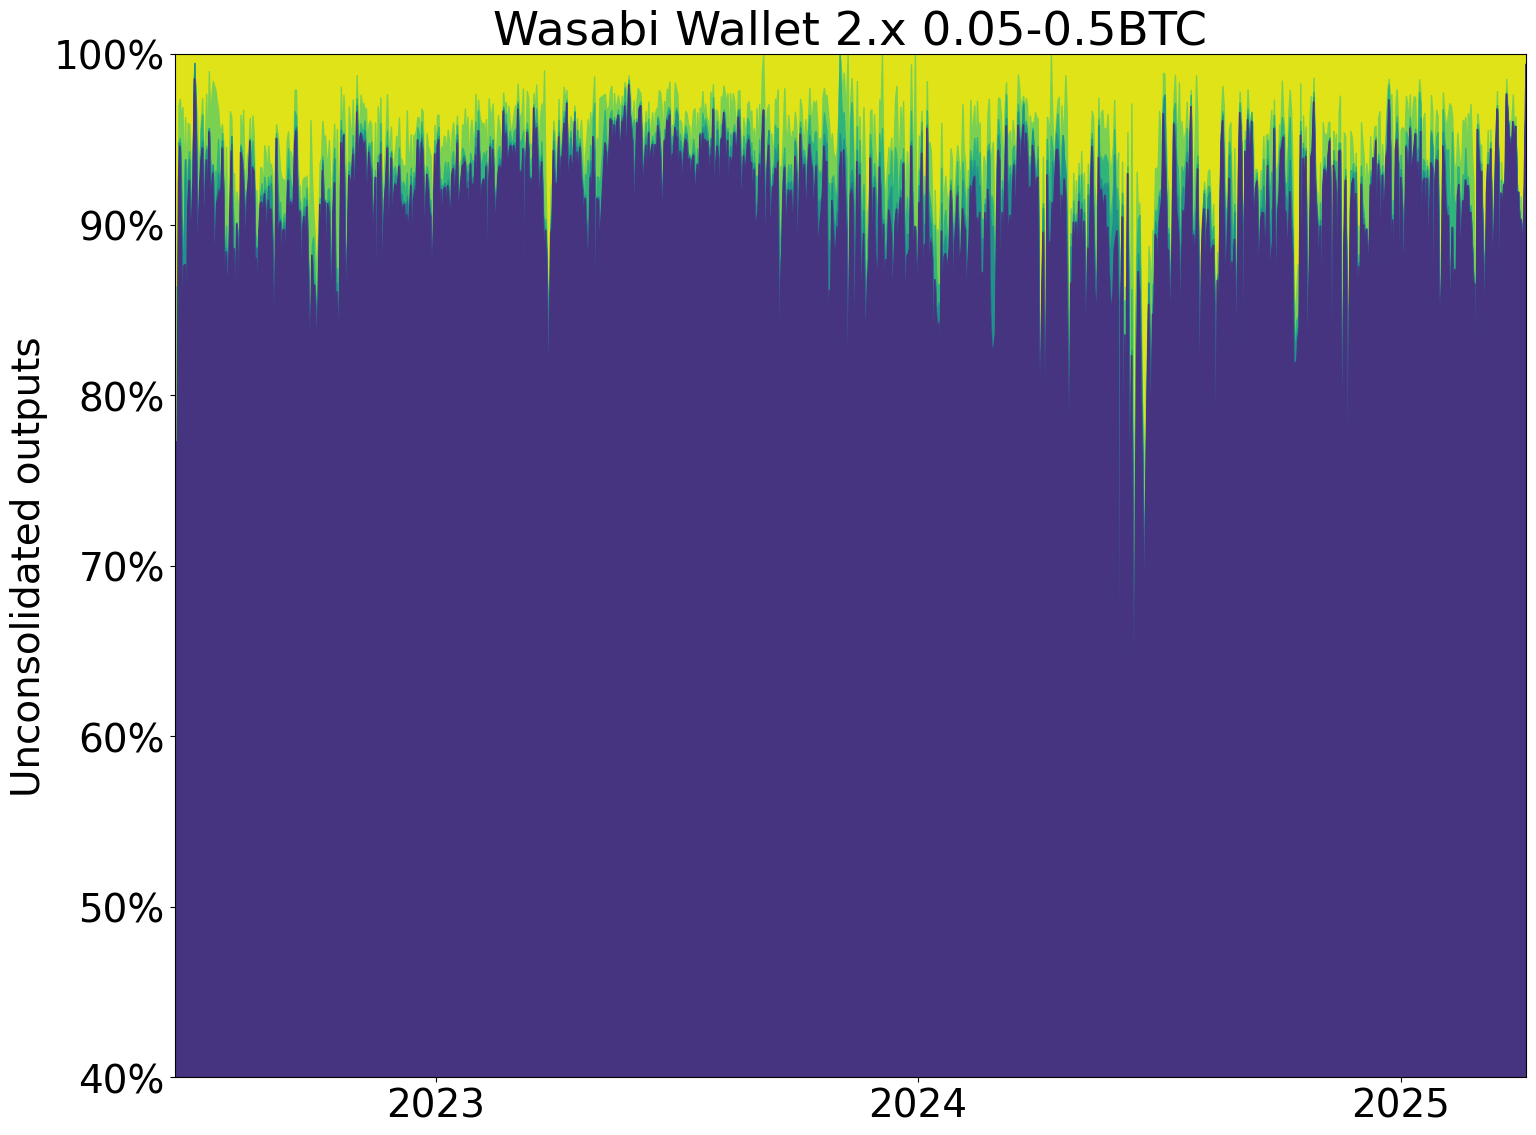

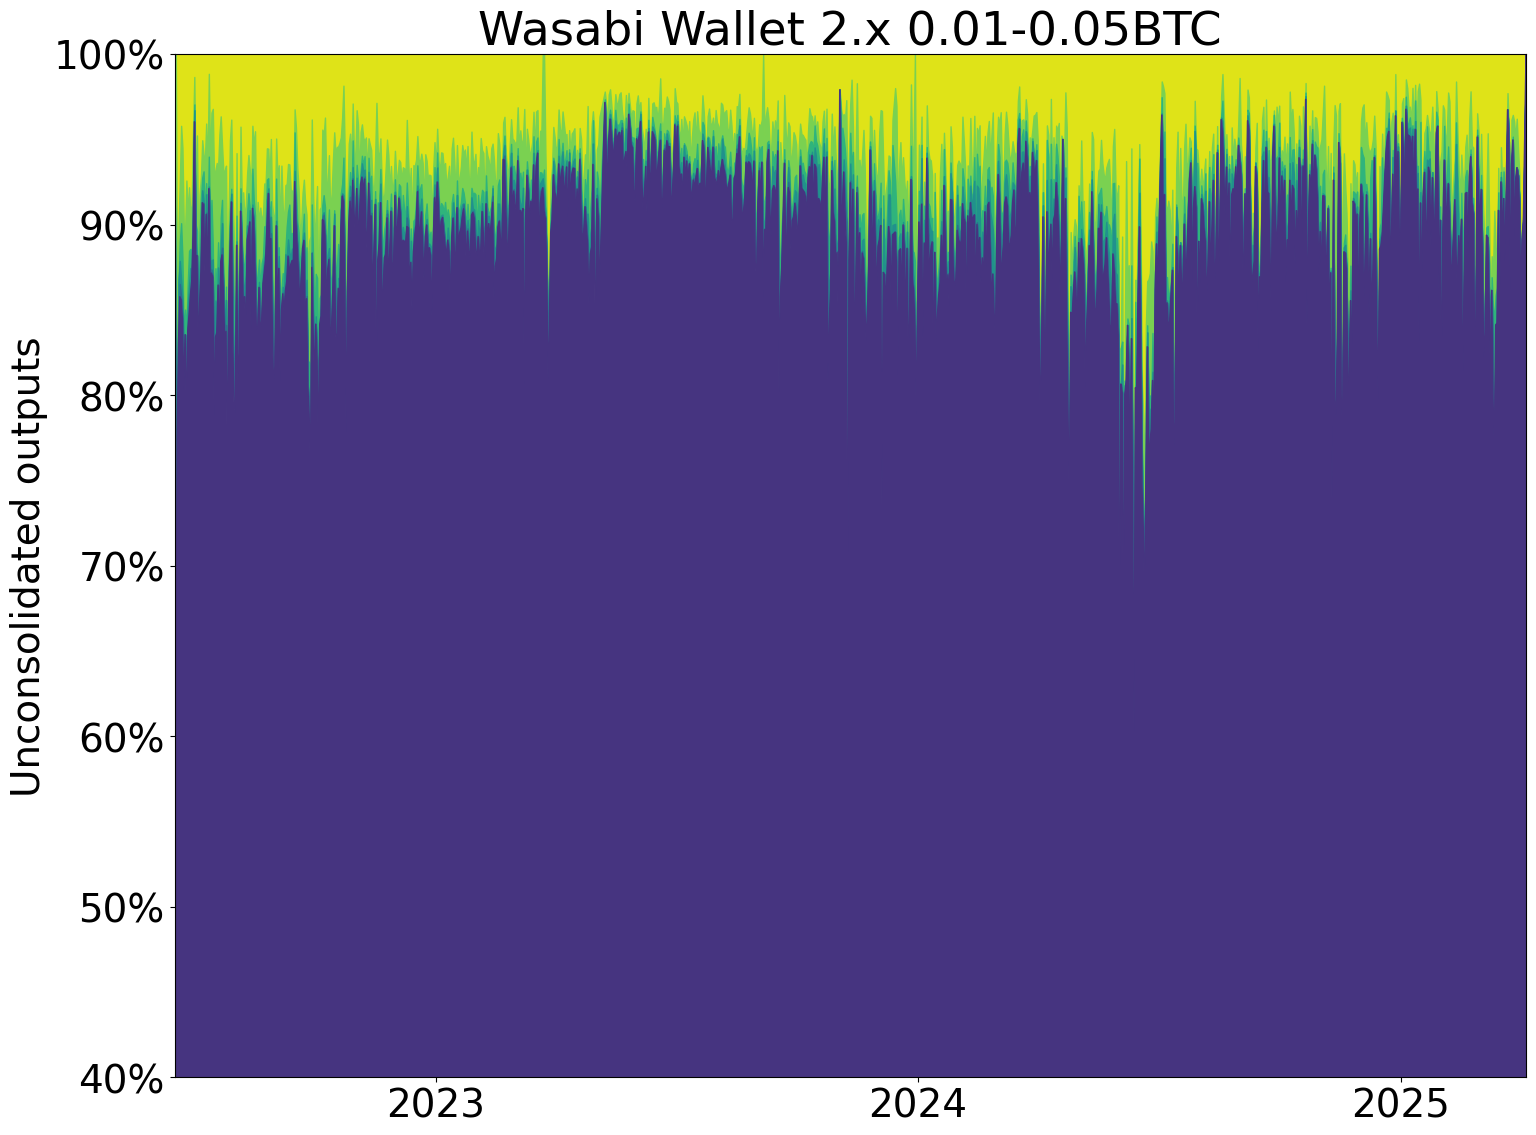

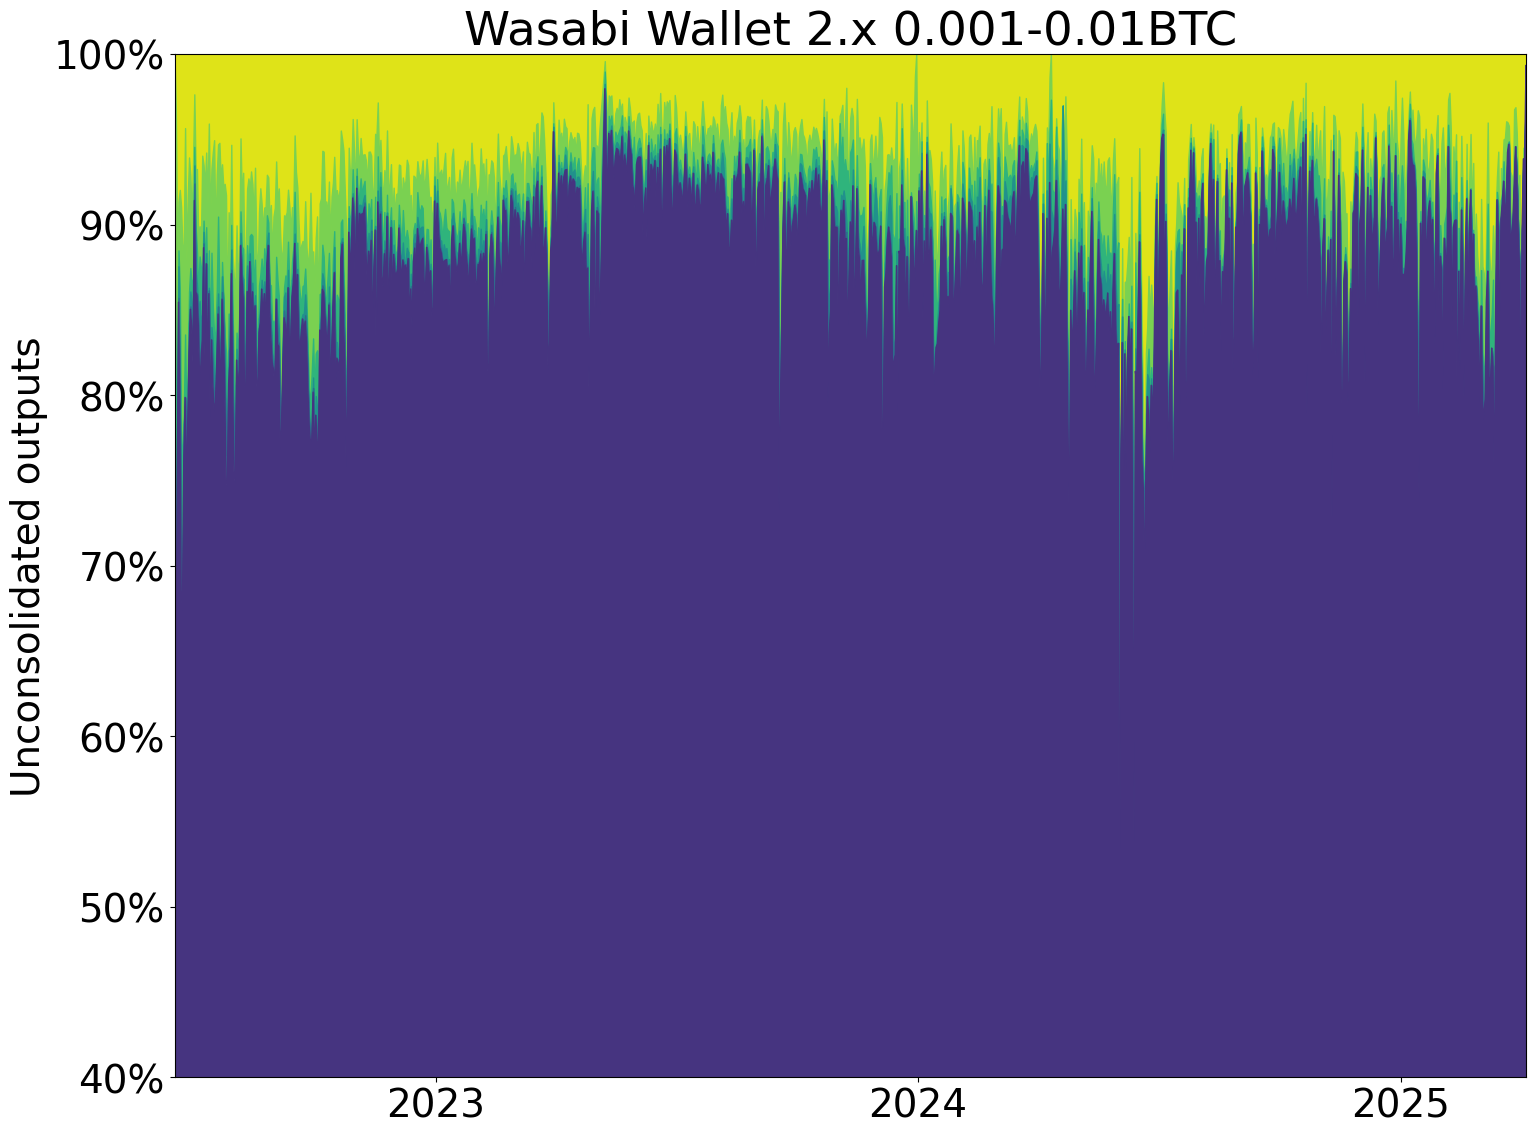

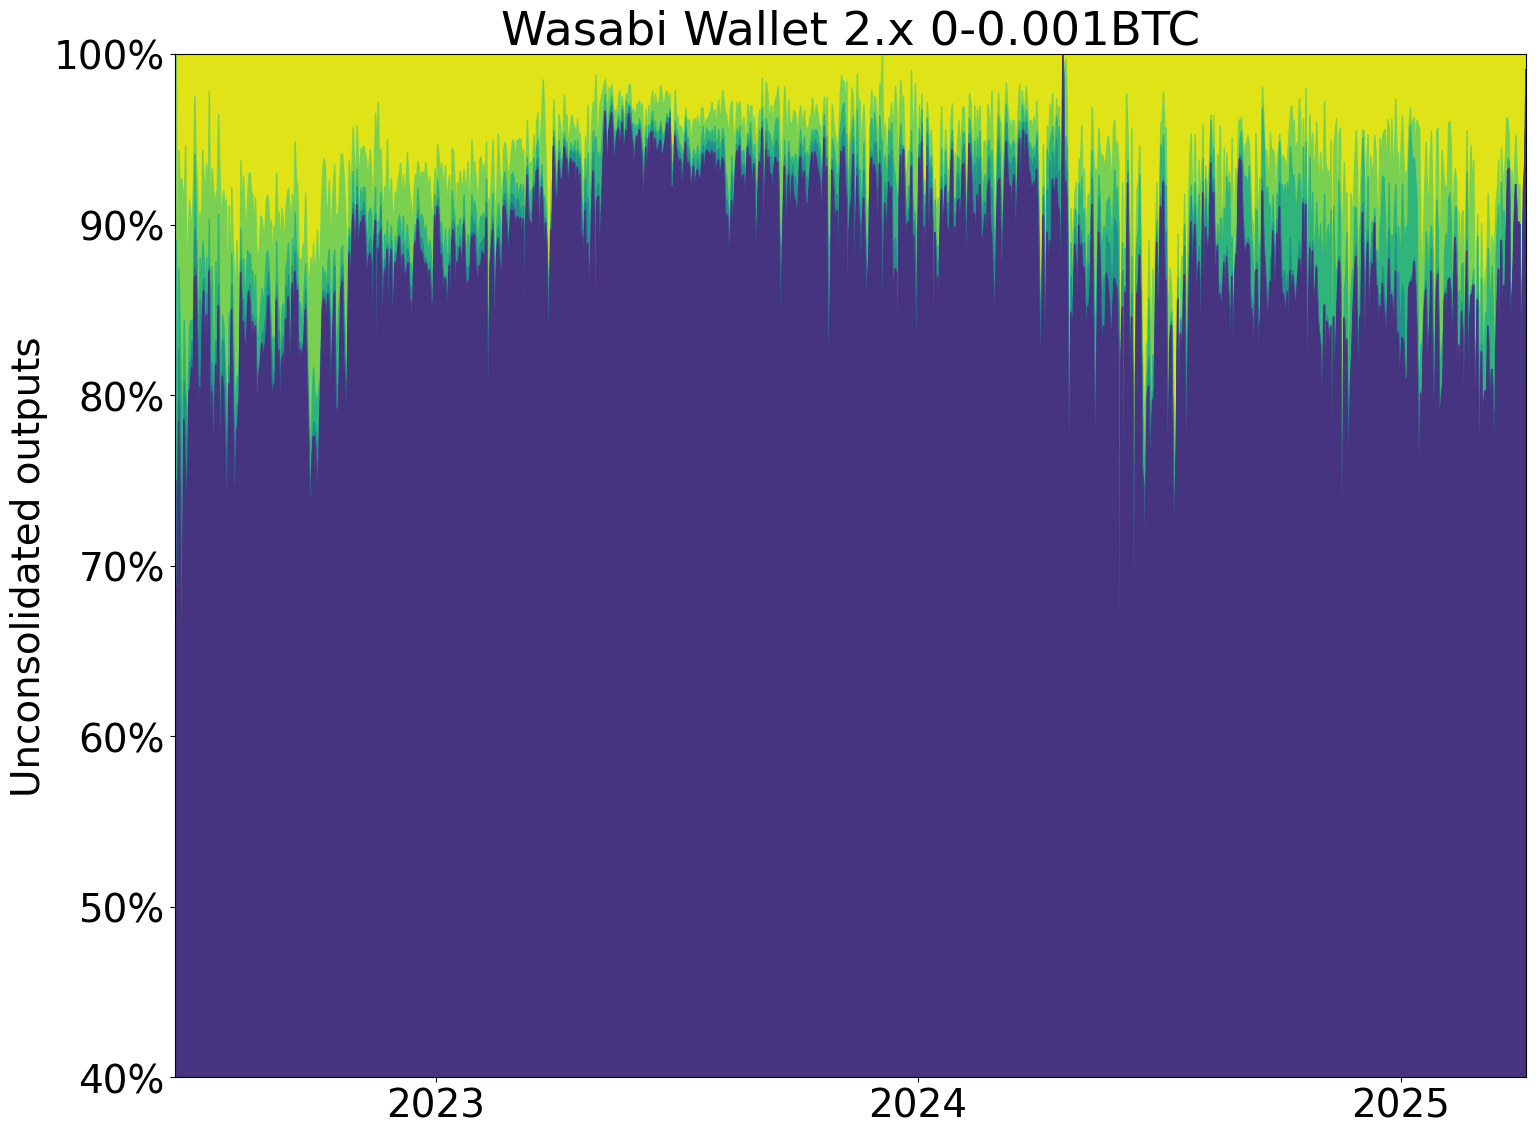

In [9]:
# plot_anonymity_degradation(
#     ww2_noremix_original_data_1b, 
#     ww2_noremix_after_day_data_1b, 
#     ww2_noremix_after_week_data_1b, 
#     ww2_noremix_after_month_data_1b, 
#     ww2_noremix_after_year_data_1b, 
#     ww2_noremix_after_full_data_1b, 
#     "ww2_multiple_txes_ignored_1b", 
#     "with remixes",
#     title="Wasabi Wallet 2.x 1-10BTC",
#     ymin=0.4,
    
# )
# plot_anonymity_degradation(
#     ww2_noremix_original_data_500m, 
#     ww2_noremix_after_day_data_500m, 
#     ww2_noremix_after_week_data_500m, 
#     ww2_noremix_after_month_data_500m, 
#     ww2_noremix_after_year_data_500m, 
#     ww2_noremix_after_full_data_500m, 
#     "ww2_multiple_txes_ignored_500m", 
#     "with remixes",
#     title="Anonymity set degradation for Wasabi Wallet 2.x 0.5-1BTC",
#     ymin=0.4,
    
# )
plot_anonymity_degradation(
    ww2_noremix_original_data_50m, 
    ww2_noremix_after_day_data_50m, 
    ww2_noremix_after_week_data_50m, 
    ww2_noremix_after_month_data_50m, 
    ww2_noremix_after_year_data_50m, 
    ww2_noremix_after_full_data_50m, 
    "ww2_multiple_txes_ignored_50m", 
    "with remixes",
    title="Wasabi Wallet 2.x 0.05-0.5BTC",
    ymin=0.4,
    
)

plot_anonymity_degradation(
    ww2_noremix_original_data_5m, 
    ww2_noremix_after_day_data_5m, 
    ww2_noremix_after_week_data_5m, 
    ww2_noremix_after_month_data_5m, 
    ww2_noremix_after_year_data_5m, 
    ww2_noremix_after_full_data_5m, 
    "ww2_multiple_txes_ignored_5m", 
    "with remixes",
    title="Wasabi Wallet 2.x 0.01-0.05BTC",
    ymin=0.4,
    
)

plot_anonymity_degradation(
    ww2_noremix_original_data_1m, 
    ww2_noremix_after_day_data_1m, 
    ww2_noremix_after_week_data_1m, 
    ww2_noremix_after_month_data_1m, 
    ww2_noremix_after_year_data_1m, 
    ww2_noremix_after_full_data_1m, 
    "ww2_multiple_txes_ignored_1m", 
    "with remixes",
    title="Wasabi Wallet 2.x 0.001-0.01BTC",
    ymin=0.4,
    
)

plot_anonymity_degradation(
    ww2_noremix_original_data_100k, 
    ww2_noremix_after_day_data_100k, 
    ww2_noremix_after_week_data_100k, 
    ww2_noremix_after_month_data_100k, 
    ww2_noremix_after_year_data_100k, 
    ww2_noremix_after_full_data_100k, 
    "ww2_multiple_txes_ignored_100k", 
    "with remixes",
    title="Wasabi Wallet 2.x 0-0.001BTC",
    ymin=0.4,
    
)


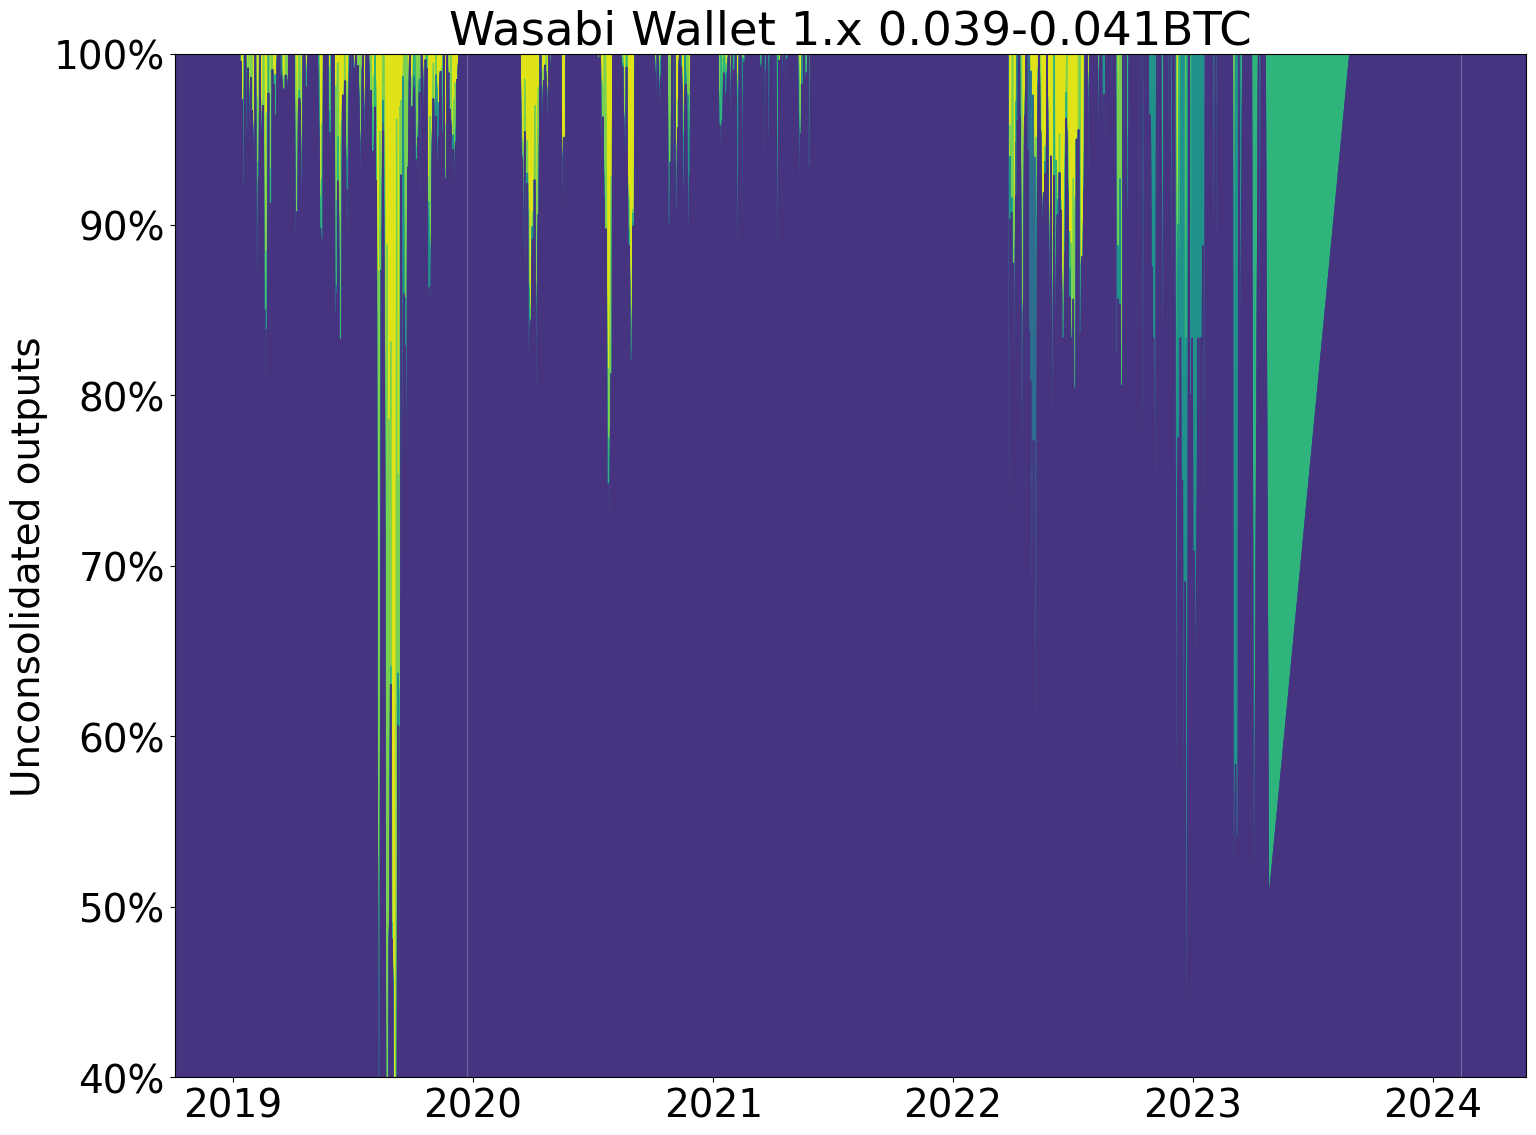

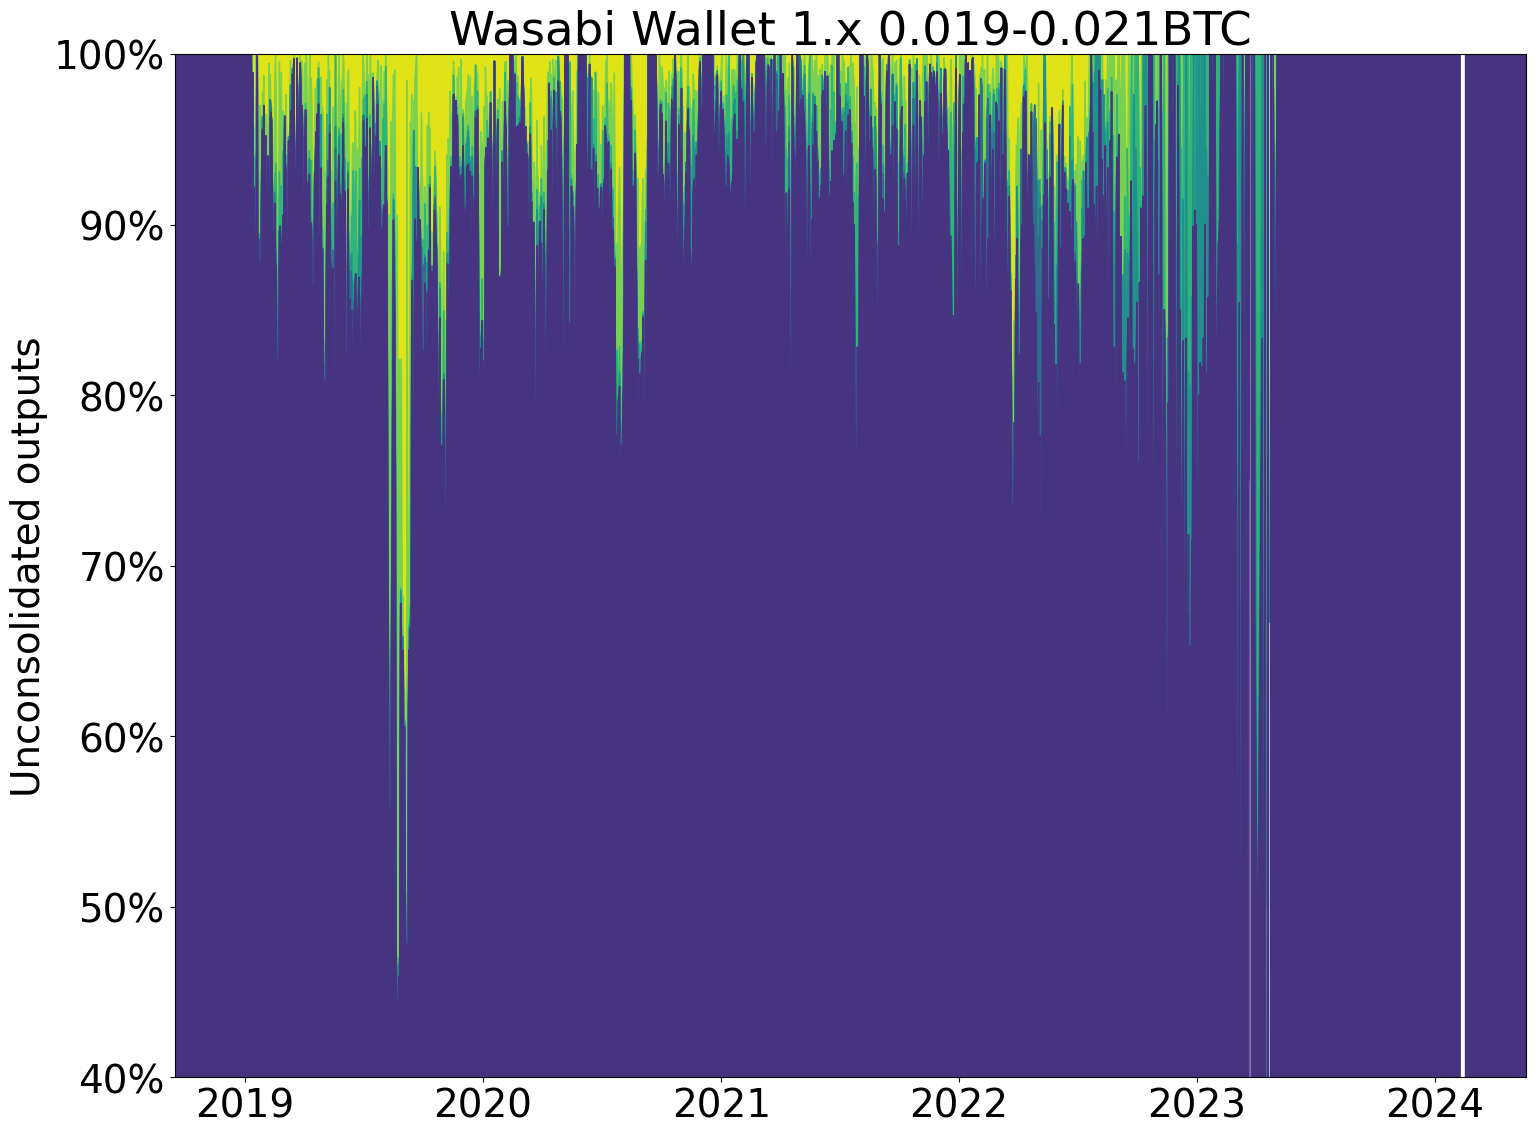

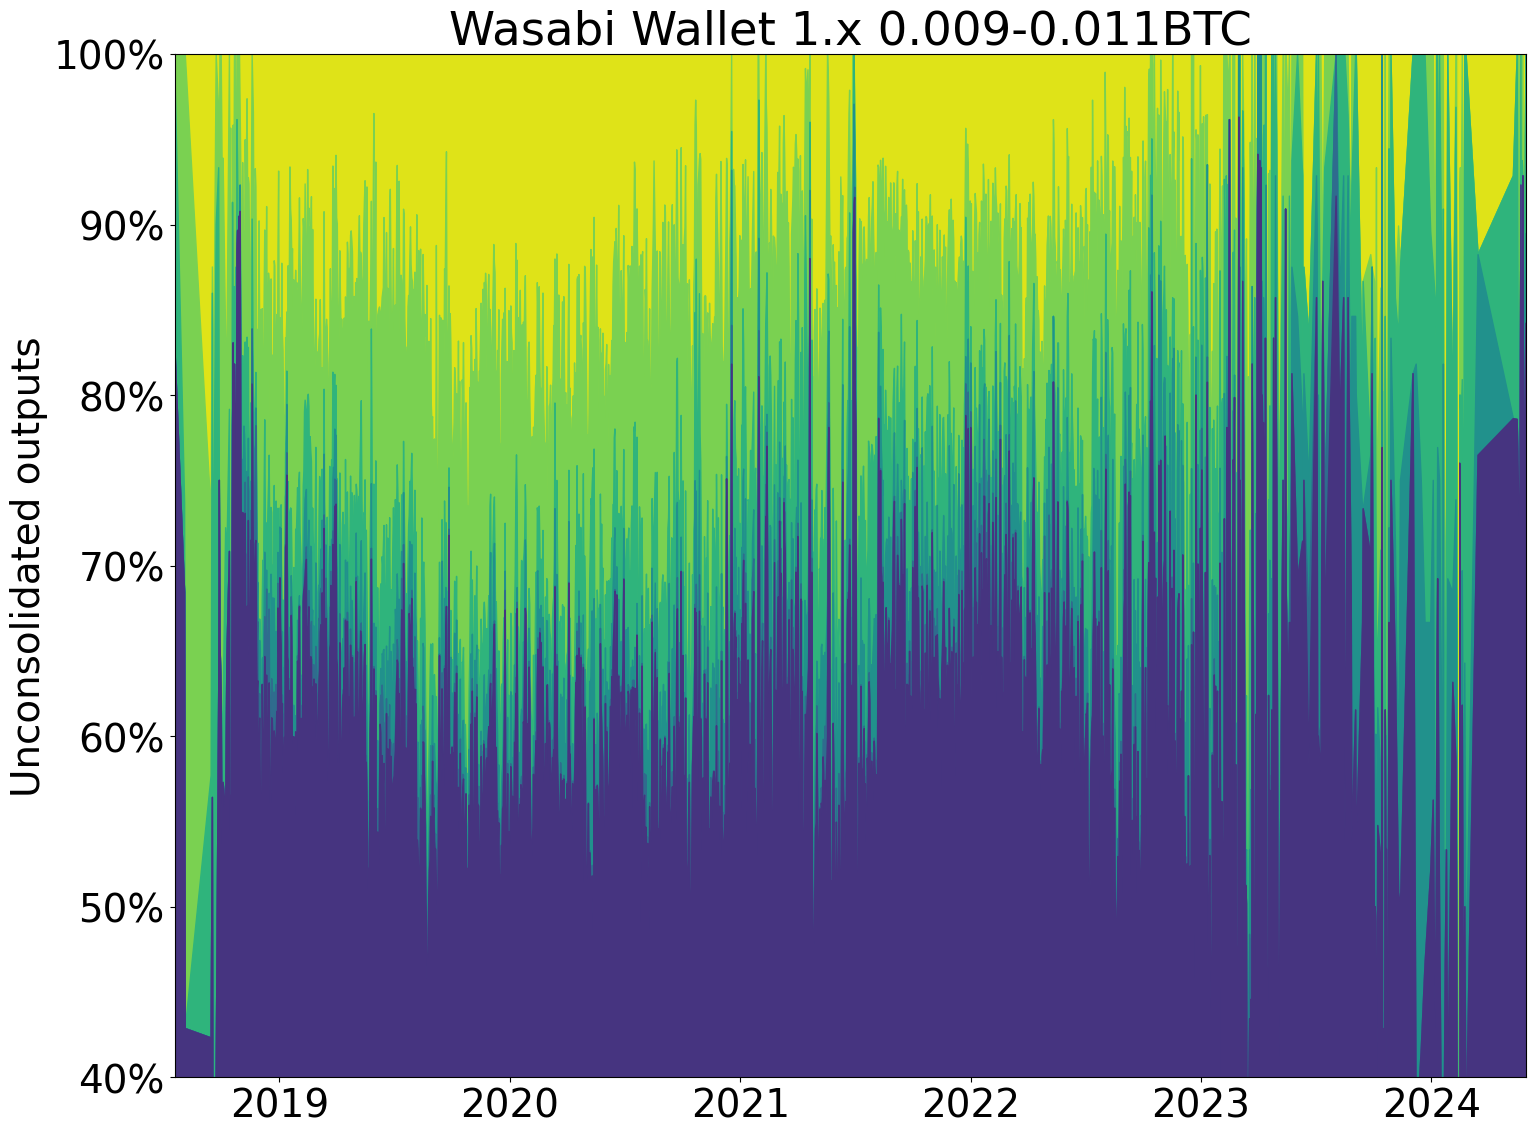

In [11]:
# plot_anonymity_degradation(
#     ww1_noremix_original_data_08, 
#     ww1_noremix_after_day_data_08, 
#     ww1_noremix_after_week_data_08, 
#     ww1_noremix_after_month_data_08, 
#     ww1_noremix_after_year_data_08, 
#     ww1_noremix_after_full_data_08, 
#     "ww1_multiple_txes_ignored_08", 
#     "with remixes",
#     title="Anonymity set degradation for Wasabi Wallet 1.x 0.04-0.08BTC",
#     ymin=0.4,
#     until='2024-06-01'
    
# )

plot_anonymity_degradation(
    ww1_noremix_original_data_04, 
    ww1_noremix_after_day_data_04, 
    ww1_noremix_after_week_data_04, 
    ww1_noremix_after_month_data_04, 
    ww1_noremix_after_year_data_04, 
    ww1_noremix_after_full_data_04, 
    "ww1_multiple_txes_ignored_04", 
    "with remixes",
    title="Wasabi Wallet 1.x 0.039-0.041BTC",
    ymin=0.4,
    until='2024-06-01'
)

plot_anonymity_degradation(
    ww1_noremix_original_data_022, 
    ww1_noremix_after_day_data_022, 
    ww1_noremix_after_week_data_022, 
    ww1_noremix_after_month_data_022, 
    ww1_noremix_after_year_data_022, 
    ww1_noremix_after_full_data_022, 
    "ww1_multiple_txes_ignored_022", 
    "with remixes",
    title="Wasabi Wallet 1.x 0.019-0.021BTC",
    ymin=0.4,
    until='2024-06-01'
)

plot_anonymity_degradation(
    ww1_noremix_original_data_012, 
    ww1_noremix_after_day_data_012, 
    ww1_noremix_after_week_data_012, 
    ww1_noremix_after_month_data_012, 
    ww1_noremix_after_year_data_012, 
    ww1_noremix_after_full_data_012, 
    "ww1_multiple_txes_ignored_012", 
    "with remixes",
    title="Wasabi Wallet 1.x 0.009-0.011BTC",
    ymin=0.4,
    until='2024-06-01'    
)


In [8]:
def create_standalone_legend(labels, colors, alphas=None, figsize=(4, 3), title=None, ncol=1, bbox_to_anchor=None):
    """
    Create a standalone legend figure.
    
    Parameters:
    -----------
    labels : list
        List of labels for the legend
    colors : list
        List of colors matching the labels
    alphas : list, optional
        List of alpha values for each patch, defaults to 0.7 for all
    figsize : tuple, optional
        Size of the figure (width, height)
    title : str, optional
        Title for the legend
    ncol : int, optional
        Number of columns in the legend
    bbox_to_anchor : tuple, optional
        Where to position the legend within the figure
        
    Returns:
    --------
    fig : Figure
        The standalone legend figure
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    if alphas is None:
        alphas = [1] * len(labels)  # Default alpha value for all patches

    plt.rcParams.update({'font.size': 32})

    
    # Create a new figure
    fig = plt.figure(figsize=figsize)
    
    # Create a list of patches as dummy handles for the legend
    handles = [mpatches.Patch(color=colors[i], alpha=alphas[i], label=labels[i]) 
              for i in range(len(labels))]
    
    # Add the legend to the figure
    if bbox_to_anchor is None:
        # Center the legend in the figure
        legend = fig.legend(handles=handles, labels=labels, loc='center', 
                          ncol=ncol, frameon=True, title=title)
    else:
        legend = fig.legend(handles=handles, labels=labels, 
                          bbox_to_anchor=bbox_to_anchor, loc='center', 
                          ncol=ncol, frameon=True, title=title)
    
    # Adjust the figure to fit just the legend
    fig.tight_layout()
    
    return fig

# Example usage with your existing code
# Place this after you've defined your colors but before or after your main plot

legend_labels = [
    "Degradation within 1 day",
    "Degradation: 1 day - 1 week",
    "Degradation: 1 week - 1 month",
    "Degradation: 1 month - 1 year",
    "Degradation: 1 year - All time",
    "Remaining anonymity (All time)"
]

# Using the same colors from your main plot
legend_colors = plt.cm.viridis([0.95, 0.8, 0.65, 0.5, 0.35, 0.15])

# Create the standalone legend figure
legend_fig = create_standalone_legend(
    labels=legend_labels,
    colors=legend_colors,
    figsize=(16, 12),  # Width, height
    ncol=1,           # Number of columns
    title="Anonymity set degradation periods"
)

# Save the legend to a file
legend_fig.savefig(f"/mnt/blocksci/results/jura/legend_anonymity_degradation.png", 
                  bbox_inches='tight', dpi=300)
plt.show(legend_fig)


<Figure size 1600x1200 with 0 Axes>

# smal cjs

In [13]:
import requests
resp = requests.get("https://raw.githubusercontent.com/crocs-muni/coinjoin-analysis/refs/heads/main/data/wasabi2/txid_coord.json?token=GHSAT0AAAAAADCIZSGAOIANQHW6GKDZNAEK2AKEHMA")
tx_hashes = set(resp.json().keys())
print(len(tx_hashes))

19621


In [21]:
# res = chain.get_consolidations_from_input_set(0, len(chain), tx_hashes)

txes = []
for h in tx_hashes:
    try:
        txes.append(chain.tx_with_hash(h))
    except Exception:
        print(h)

print(len(txes))

9ff39e990c00169e55c01cc203d991ad3531b552d339f0a8e2e5f785ca3ba5af
be06f7edbee88940c0ac65e5e5618585e3b0d323a0cdc77009be5e8d664d0a8f
1e35f111dd705476b1634f833d39d7009e04be016438af643dc7d123f8a5e020
9b96c897b91cbf1bf8967056aa426312f4033b64e16dfa4a907771aee0a508d7
832d7cb807d1a321519b692b0a7e6373ae6bce694ea9678950b21af3255b6653
3a5bfb8bd06e9e0fa3b4b60e975993150e44ce68eb27d25d280cd2674565eec8
1a1bdccf6e281de90b837e81a586ac648a687b44142ce5f1b6edcf69b5860c95
e01c3d21d3c3b37adeba749376b53ff0256900e2fe912166d7f45a384127a47a
fd2297822e1a382f4f188df696ffe8fb860b3ff9e9bb5effc0bd7dbe3232e6d8
81d24d45b7429ca0124655d3a9e7f7dd9712a1cdbf088f07c0a2f16b01fd201c
7d225f22724a23ca3ac0717038394259486d187fc2aa8858a56bbd766f41fd74
22302d3fb2cb8d117d1b978d9cf67bc7468730f4fa13887966b2fda96faf3ca1
19609


In [74]:
tx: blocksci.Tx
o: blocksci.Output
inp: blocksci.Input

res = {}
for tx in txes:
    if not (32 <= tx.input_count + tx.output_count <= 32):
        continue
    for o in tx.outputs:
        inps = []
        if not o.is_spent:
            continue
        if o.spending_tx.output_count != 1:
            continue
        for inp in o.spending_tx.inputs:
            if inp.spent_tx == tx:
                inps.append(inp.spent_output)

        if len(inps) > 1:
            if str(tx.hash) not in res:
                res[str(tx.hash)] = []
            if inps in res[str(tx.hash)]:
                continue
            res[str(tx.hash)].append(inps)

print(len(res))
    

4


In [91]:
import json
print(
    json.dumps(
        {
            cjtx: [
                {
                    "remix": False, 
                    "value": x.value, 
                    "address":str(x.address) if str(x.address) != "WitnessUnknownScript()" else "taproot_unknown"
                }
                 for val in r for x in val
            ]
            for cjtx, r in res.items() 
        }, 
        indent=2
    )
)

{
  "ab003f70640f02c4cb7edca54591d1f82d8af750aa5be850d2a876bf105ee458": [
    {
      "remix": false,
      "value": 65536,
      "address": "bc1qa3jhgqda6wqxcxzvk7nkc0uw2ljh879x69sslu"
    },
    {
      "remix": false,
      "value": 2000000,
      "address": "bc1qa62nnffznzu7h9r2lk9gqfyzyxed29z84yepwf"
    },
    {
      "remix": false,
      "value": 65536,
      "address": "bc1q2vxmp6ygpkcltqz3cdvxttn9ze3ptsq528xf9j"
    },
    {
      "remix": false,
      "value": 2000000,
      "address": "bc1q0gtrh6un400qxdz4qp9e4vj6kkcy2faeyckce2"
    },
    {
      "remix": false,
      "value": 65536,
      "address": "bc1qnp2w9f77w5tz0qrc03wjytnvw9aa3u6zenntn4"
    },
    {
      "remix": false,
      "value": 2000000,
      "address": "taproot_unknown"
    },
    {
      "remix": false,
      "value": 65536,
      "address": "bc1q2srfr6s9y75lf9zy8wfy0elq2drxkz7nv04p2d"
    },
    {
      "remix": false,
      "value": 2000000,
      "address": "taproot_unknown"
    },
    {
      "remix":

# old vvvv

In [8]:
%time ww1_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ignoreNonStandardDenominations=True)

CPU times: user 2min 48s, sys: 411 ms, total: 2min 49s
Wall time: 2.47 s
CPU times: user 27min 32s, sys: 453 ms, total: 27min 32s
Wall time: 11.3 s
CPU times: user 28min 24s, sys: 2.53 s, total: 28min 27s
Wall time: 11.9 s
CPU times: user 28min 25s, sys: 2.35 s, total: 28min 27s
Wall time: 12.6 s
CPU times: user 28min 37s, sys: 638 ms, total: 28min 37s
Wall time: 12.4 s
CPU times: user 28min 29s, sys: 929 ms, total: 28min 30s
Wall time: 12.6 s


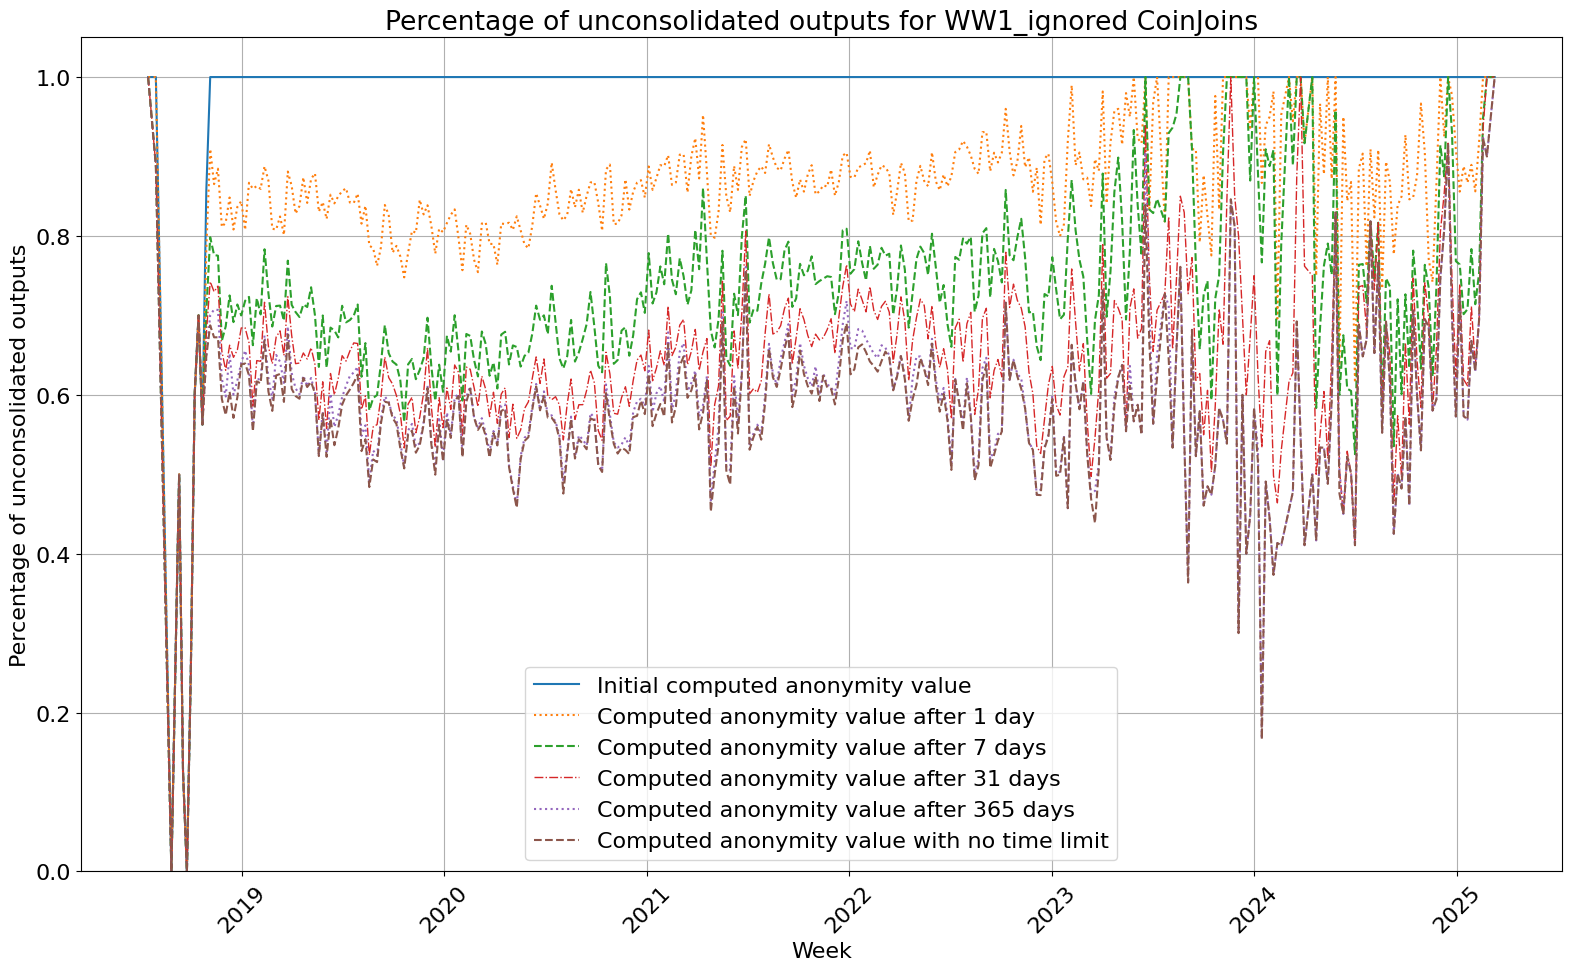

In [14]:
plot_anonymity_degradation(ww1_ign_original_data, ww1_ign_after_day_data, ww1_ign_after_week_data, ww1_ign_after_month_data, ww1_ign_after_year_data, ww1_ign_after_full_data, "ww1_multiple_txes", "ignored")
# compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
# compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")
